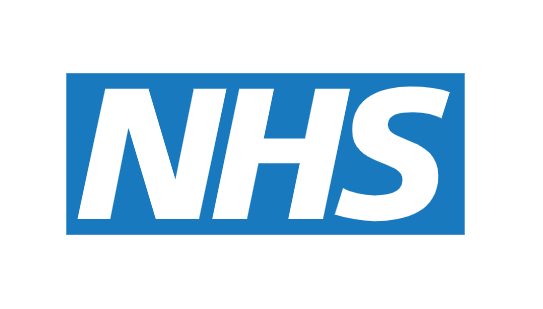

<div style="background-color:#005EB8; color:white; padding:20px; text-align:center; font-weight:bold; border-radius: 8px; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);">

<h2 style="font-size: 24px;">Diagnostic Analysis for NHS Staffing and Resource Utilization</h2>
    
</div>


# Data Analytics using Python


## 1) Analytical Approach


In [400]:
# Document the planned analytical approach.

##### Step 1. Problem Definition: 
NHS aims to reduce DNAs(Did Not attend) appointments in order to improve health inequalities, waste staff resources and reduce organisational costs.

This analisys will inform decision-making regarding the utilisation trends of each component of the network. 

In particular, it will focus on two overarching objects: 

.Evaluate whether there has been adequate staff and capacity and if this related to DNAs 
.Determine the resource utilisation across the network 


#### Step 2 Data ingestion and wrangling
of the available datasets: actual_duration.csv, appointments_regional.csv, national_categories.xlsx, tweets.csv.

- Data validation
- Check for missing values and Duplicates
- Descriptive Statistics 

Key variable of interest: Since we are interest in understanding trends and patterns in the newtwork, we will focus on analysis of locations, trends over time, appointemnt types and service setting provider.  

#### Step 3. Explororatory DATA Analysis (EDA )

part 1: Univariate Statistics: Analysis related to distribution of rersouces across the networks (Appointments,Popularity of Service Setting, Appointments Types, Attendance, Mode of appointment and Locations) 
part 2: bivariate : Analysis of trends over time



#### Step 4 : Diagnostic Analysis and Insights

Utilization Trends: Analysis related to the utilization of services.
Missed Appointments: Analysis related to missed appointments and potential causes.
Sentiment Analysis involving external data sources like Twitter (X)


# 

### Prepare your workstation

In [286]:
# Import the necessary libraries.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import *
from sklearn.preprocessing import MaxAbsScaler

from matplotlib.ticker import StrMethodFormatter
import re
from textblob import TextBlob #pip install textblob
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords 
from wordcloud import WordCloud #pip install wordcloud
from scipy.stats import linregress

nltk.download('punkt')
nltk.download('stopwords')

# Optional - Ignore warnings.
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rossi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rossi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [146]:
# User Defines Functions: 
def group_2variables_by_cnt_appointments(df, x, y):
    '''This function groups by specified variables (x, y), sums by count_of_appointments and reset index.'''
    grouped_df = df.groupby([x, y])['count_of_appointments'].sum().reset_index(name='total_appointment')
    return grouped_df


def group1_apply_operation(df, x, y, operation):
    '''
    This function groups by one specified variables (x) and apply specified operation on column y
    '''
    grouped_df = df.groupby(x)[y].apply(operation).reset_index()
    return grouped_df


def group2_apply_operation (df,x,y,z,operation):
    '''
    This function groups by two specified variables (x, y) and apply specified operation on column z
    '''
    grouped_df= df.groupby([x, y])[z].apply(operation).reset_index()
    return grouped_df


def calculate_min_max_dates(df, column_name):
    """Calculate the minimum and maximum dates in the specified column of the DataFrame"""
    min_date = df[column_name].min()
    max_date = df[column_name].max()
    return min_date, max_date

def variable_count(df,x):
    print('Record Count: ')
    value_counts = df[x].value_counts().reset_index()
    print(value_counts)
        

def validate_data(df):
    #check for unique values
    unique_counts = df.nunique()
    print("Unique values per column:")
    print(unique_counts)
    
    #checking for duplicates
    duplicate_count = df.duplicated().sum()
    print("\nNumber of duplicate rows:")
    print(duplicate_count)
    
    #summary stats
    summary_stats = df.describe()
    print("\nSummary statistics:")
    print(summary_stats) 
    
    return unique_counts, duplicate_count, summary_stats

def ingest_data(df):
    print('DataFrame shape:', df.shape)
    
    # Print the data types of each column
    data_types = df.dtypes
    print('\nData types:')
    print(data_types)
    
    # Print the number of missing values in each column
    missing_values = df.isna().sum()
    print('\nNumber of missing values:')
    print(missing_values)
    
    return missing_values, data_types


def transform_datetype(df,column):
    ''' This function transform string to date type with the specified format present in the analysis datasets.
    If different df with diverse formats will be added, just amend the try/except blocks with the new format. 
    '''
    try:
        # Try to convert using the specified format
        date_type = pd.to_datetime(df[column], format='%Y-%m-%d')
        print("Converted using format '%Y-%m-%d'")
    except ValueError:
        try:
            # If fails, try converting using alternative format
            date_type = pd.to_datetime(df[column], format='%d-%b-%y')
            print("Converted using format '%d-%b-%y'")
        except ValueError:
            try:
                # if fails, convert using the specified format 
                date_type = pd.to_datetime(df[column], format='%Y-%m')
                print("Converted using format '%Y-%m'")
            except ValueError:
                print("Conversion failed")
                pass
    return date_type

           

#function to clean labels if it's names like product_category, turns into Product Category
def clean_label(label):
    return label.replace('_', ' ').title()

def generate_standard_bar_chart(df, x, y, title="Bar Chart", **kwargs):
    x_label = clean_label(x)
    y_label = clean_label(y)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x=x, y=y, **kwargs)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
def generate_customised_line_chart(df, x, y, title="Bar Chart", **kwargs):
    x_label = clean_label(x)
    y_label = clean_label(y)

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x=x, y=y, **kwargs)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    

# Function to clean tweet text for sentiment analysis.
def clean_text(text):
    '''User defined function to clean tweet text by removing links, RT, and special characters.
    It splits the text in tokens and remove stopwords'''
    # Convert to lower case
    text = text.lower()
    # Remove links
    text = re.sub(r"https\S+|www\S+https\S+", '', text, flags=re.MULTILINE)
    # Remove hashtags, retweets and mentions
    text = re.sub(r'@\w+|\#|rt', '', text) 
    # Remove special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Split the text in tokens
    text_tokens = word_tokenize(text)
    # Remove stop words 
    filtered_text = [w for w in text_tokens if not w in stop_words]
    # Then return join filtered text
    return " ".join(filtered_text)

# Define a function for assessing the sentiment score of the tweet text
def polarity(text):
    ''' This function uses Textblob sentiment method to calculate the polarity'''
    return TextBlob(text).sentiment.polarity

    
def max_abs_scaling(df):
    '''this function apply max and abs methods to df or series to scale the dataset'''
    # Copy the DataFrame.
    df_scaled = df.copy()
    # if input is df
    if isinstance(df_scaled, pd.DataFrame):
        # Apply maximum absolute scaling.
        for column in df_scaled.columns:
            df_scaled[column] = df_scaled[column] / df_scaled[column].abs(
            ).max()
    else:
        # If the input is not a df, scale the series
        df_scaled = df_scaled / df_scaled.abs().max()
        
    return df_scaled


# Set ANSI escape sequences for bold text
bold_start = "\033[1m"
bold_end = "\033[0m"

In [147]:
### Load The Data

In [148]:
# Import datasets
ad = pd.read_csv('actual_duration.csv')
ar = pd.read_csv('appointments_regional.csv')
nc = pd.read_excel('national_categories.xlsx')
location_df = pd.read_excel('ICB_JUL_2022_EN_NC.xlsx')
tweets = pd.read_csv('tweets.csv')
gp = pd.read_excel('NHS GP Workforce Statistics.xlsx')


In [149]:
# Validate ar
validate_data(ar)

Unique values per column:
icb_ons_code                            42
appointment_month                       30
appointment_status                       3
hcp_type                                 3
appointment_mode                         5
time_between_book_and_appointment        8
count_of_appointments                22807
dtype: int64

Number of duplicate rows:
21604

Summary statistics:
       count_of_appointments
count          596821.000000
mean             1244.601857
std              5856.887042
min                 1.000000
25%                 7.000000
50%                47.000000
75%               308.000000
max            211265.000000


(icb_ons_code                            42
 appointment_month                       30
 appointment_status                       3
 hcp_type                                 3
 appointment_mode                         5
 time_between_book_and_appointment        8
 count_of_appointments                22807
 dtype: int64,
 21604,
        count_of_appointments
 count          596821.000000
 mean             1244.601857
 std              5856.887042
 min                 1.000000
 25%                 7.000000
 50%                47.000000
 75%               308.000000
 max            211265.000000)

**Detected 21604 number of duplicates rows in ar dataset

In [150]:
# Validate nc
validate_data(nc)

Unique values per column:
appointment_date          334
icb_ons_code               42
sub_icb_location_name     106
service_setting             5
context_type                3
national_category          18
count_of_appointments    9957
appointment_month          11
dtype: int64

Number of duplicate rows:
0

Summary statistics:
                    appointment_date  count_of_appointments
count                         817394          817394.000000
mean   2022-01-16 00:50:35.860796160             362.183684
min              2021-08-01 00:00:00               1.000000
25%              2021-10-25 00:00:00               7.000000
50%              2022-01-18 00:00:00              25.000000
75%              2022-04-07 00:00:00             128.000000
max              2022-06-30 00:00:00           16590.000000
std                              NaN            1084.576600


(appointment_date          334
 icb_ons_code               42
 sub_icb_location_name     106
 service_setting             5
 context_type                3
 national_category          18
 count_of_appointments    9957
 appointment_month          11
 dtype: int64,
 0,
                     appointment_date  count_of_appointments
 count                         817394          817394.000000
 mean   2022-01-16 00:50:35.860796160             362.183684
 min              2021-08-01 00:00:00               1.000000
 25%              2021-10-25 00:00:00               7.000000
 50%              2022-01-18 00:00:00              25.000000
 75%              2022-04-07 00:00:00             128.000000
 max              2022-06-30 00:00:00           16590.000000
 std                              NaN            1084.576600)

In [151]:
# Validate location_df
validate_data(location_df)

Unique values per column:
ICB22CD     42
ICB22CDH    42
ICB22NM     42
dtype: int64

Number of duplicate rows:
0

Summary statistics:
          ICB22CD ICB22CDH                                            ICB22NM
count          42       42                                                 42
unique         42       42                                                 42
top     E54000008      QYG  NHS Cheshire and Merseyside Integrated Care Board
freq            1        1                                                  1


(ICB22CD     42
 ICB22CDH    42
 ICB22NM     42
 dtype: int64,
 0,
           ICB22CD ICB22CDH                                            ICB22NM
 count          42       42                                                 42
 unique         42       42                                                 42
 top     E54000008      QYG  NHS Cheshire and Merseyside Integrated Care Board
 freq            1        1                                                  1)

In [152]:
# Validate gp_stats
validate_data(gp)

Unique values per column:
Region Code               7
Area                      7
Month                     8
Total                    50
GP Partners              50
Salaried GPs             50
GPs in Training Grade    50
GP Retainers             50
GP Regular Locums        50
dtype: int64

Number of duplicate rows:
0

Summary statistics:
                     Month        Total  GP Partners  Salaried GPs  \
count                   56    56.000000    56.000000     56.000000   
mean   2022-03-17 03:00:00  4987.311305  2413.849211   1402.024738   
min    2021-12-01 00:00:00  3615.977948  1836.787375    958.669363   
25%    2022-01-24 06:00:00  3791.369921  1974.314356   1093.475129   
50%    2022-03-16 12:00:00  4944.230569  2381.018344   1453.322595   
75%    2022-05-08 18:00:00  5395.308835  2617.925439   1731.124168   
max    2022-07-01 00:00:00  7055.195078  3319.109427   1894.882787   
std                    NaN  1039.987880   453.737876    307.372681   

       GPs in Training Grade

(Region Code               7
 Area                      7
 Month                     8
 Total                    50
 GP Partners              50
 Salaried GPs             50
 GPs in Training Grade    50
 GP Retainers             50
 GP Regular Locums        50
 dtype: int64,
 0,
                      Month        Total  GP Partners  Salaried GPs  \
 count                   56    56.000000    56.000000     56.000000   
 mean   2022-03-17 03:00:00  4987.311305  2413.849211   1402.024738   
 min    2021-12-01 00:00:00  3615.977948  1836.787375    958.669363   
 25%    2022-01-24 06:00:00  3791.369921  1974.314356   1093.475129   
 50%    2022-03-16 12:00:00  4944.230569  2381.018344   1453.322595   
 75%    2022-05-08 18:00:00  5395.308835  2617.925439   1731.124168   
 max    2022-07-01 00:00:00  7055.195078  3319.109427   1894.882787   
 std                    NaN  1039.987880   453.737876    307.372681   
 
        GPs in Training Grade  GP Retainers  GP Regular Locums   
 count       

### Data Cleaning and Transformation


In [153]:
# Check for missing values and data types across all datasets
#call defined function

print(f"{bold_start}AR DataFrame:{bold_end}")
ingest_data(ar);

print(f"{bold_start}NC DataFrame:{bold_end}")
ingest_data(nc);

print(f"{bold_start}AD DataFrame:{bold_end}")
ingest_data(ad);

print(f"{bold_start}GP DataFrame:{bold_end}")
ingest_data(gp);




AR DataFrame:
DataFrame shape: (596821, 7)

Data types:
icb_ons_code                         object
appointment_month                    object
appointment_status                   object
hcp_type                             object
appointment_mode                     object
time_between_book_and_appointment    object
count_of_appointments                 int64
dtype: object

Number of missing values:
icb_ons_code                         0
appointment_month                    0
appointment_status                   0
hcp_type                             0
appointment_mode                     0
time_between_book_and_appointment    0
count_of_appointments                0
dtype: int64
NC DataFrame:
DataFrame shape: (817394, 8)

Data types:
appointment_date         datetime64[ns]
icb_ons_code                     object
sub_icb_location_name            object
service_setting                  object
context_type                     object
national_category                object
count_of_appo

There are not missing values in the ad dataset. 


#### Tranform date object data to date type format

In [154]:
# Apply the function to each DataFrame column
nc['appointment_month'] = transform_datetype(nc, 'appointment_month')
ar['appointment_month'] = transform_datetype(ar, 'appointment_month')
ad['appointment_date'] = transform_datetype(ad, 'appointment_date')
gp['Month'] = transform_datetype(gp, 'Month')

# Print the results to confirm the changes
print(nc.info())
print(ar.info())
print(ad.info())
print(gp.info())

Converted using format '%Y-%m'
Converted using format '%Y-%m'
Converted using format '%d-%b-%y'
Converted using format '%Y-%m-%d'
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 817394 entries, 0 to 817393
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   appointment_date       817394 non-null  datetime64[ns]
 1   icb_ons_code           817394 non-null  object        
 2   sub_icb_location_name  817394 non-null  object        
 3   service_setting        817394 non-null  object        
 4   context_type           817394 non-null  object        
 5   national_category      817394 non-null  object        
 6   count_of_appointments  817394 non-null  int64         
 7   appointment_month      817394 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(5)
memory usage: 49.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596821 entries, 0 to 596820
Data co

#### Handling AR Duplicates 

In [155]:
# Check for duplicate values
ar_duplicates= ar.duplicated()

# Identify duplicates 
print(ar_duplicates.tail(200))

# View the sum of duplicates 
print(ar_duplicates.sum())


596621     True
596622     True
596623    False
596624    False
596625    False
          ...  
596816    False
596817     True
596818    False
596819    False
596820     True
Length: 200, dtype: bool
21604


**Duplicated check:** True duplicated detected in the tail of ar dataset. 

In [156]:
# View duplicates rows
ar_duplicated_rows= ar[ar.duplicated(keep=False)]

# View output
ar_duplicated_rows


icb_ons_code appointment_month appointment_status  \
13236     E54000044        2020-01-01           Attended   
13252     E54000044        2020-01-01           Attended   
13307     E54000044        2020-01-01                DNA   
13332     E54000044        2020-01-01                DNA   
13349     E54000044        2020-01-01                DNA   
...             ...               ...                ...   
596809    E54000050        2022-06-01            Unknown   
596812    E54000050        2022-06-01            Unknown   
596814    E54000050        2022-06-01            Unknown   
596817    E54000050        2022-06-01            Unknown   
596820    E54000050        2022-06-01            Unknown   

                    hcp_type appointment_mode  \
13236                     GP       Home Visit   
13252                     GP          Unknown   
13307                     GP       Home Visit   
13332   Other Practice staff       Home Visit   
13349   Other Practice staff          Unknown   
...                      ...              ...   
596809               Unknown        Telephone   
596812               Unknown        Telephone   
596814               Unknown          Unknown   
596817               Unknown          Unknown   
596820               Unknown          Unknown   

       time_between_book_and_appointment  count_of_appointments  
13236             Unknown / Data Quality                      1  
13252             Unknown / Data Quality                      2  
13307                      8  to 14 Days                      1  
13332                        2 to 7 Days                      1  
13349                  More than 28 Days                     32  
...                                  ...                    ...  
596809                    15  to 21 Days                      1  
596812                 More than 28 Days                      1  
596814                             1 Day                      2  
596817                    22  to 28 Days                      8  
596820                          Same Day                     10  

[40135 rows x 7 columns]

N.b: Whilst the duplicated() method identified 21604 duplicate rows (sum of true values where True=duplicates=1), to a closer look at the duplicated displayed in ar_duplicated_rows, each instance appears unique. This is because the dataset is too large and we will inspect the rows manually. 


In [157]:
# Define examples of Duplicates. We are looking at random rows identified as True by duplicated()
row_596820 = ar.loc[596820]
row_596817 = ar.loc[596817]

print(row_596820)
print(row_596817)

icb_ons_code                                   E54000050
appointment_month                    2022-06-01 00:00:00
appointment_status                               Unknown
hcp_type                                         Unknown
appointment_mode                                 Unknown
time_between_book_and_appointment               Same Day
count_of_appointments                                 10
Name: 596820, dtype: object
icb_ons_code                                   E54000050
appointment_month                    2022-06-01 00:00:00
appointment_status                               Unknown
hcp_type                                         Unknown
appointment_mode                                 Unknown
time_between_book_and_appointment         22  to 28 Days
count_of_appointments                                  8
Name: 596817, dtype: object


In [158]:
# Filter rows by duplicate criteria 
check_dup1 = ar[(ar['icb_ons_code'] == 'E54000050') &
           (ar['appointment_month'] == '2022-06') &
           (ar['appointment_status'] == 'Unknown') &
           (ar['hcp_type'] == 'Unknown') &
           (ar['appointment_mode'] == 'Unknown') &
           (ar['time_between_book_and_appointment'] == 'Same Day')]
# Filter rows by duplicate attributes criteria 
check_dup2 = ar[(ar['icb_ons_code'] == 'E54000050') &
           (ar['appointment_month'] == '2022-06') &
           (ar['appointment_status'] == 'Unknown') &
           (ar['hcp_type'] == 'Unknown') &
           (ar['appointment_mode'] == 'Unknown') &
           (ar['time_between_book_and_appointment'] ==  '22  to 28 Days')]

# View Dup.
print(f'Check 1: {check_dup1}')
print(f'Check 2: {check_dup2}')


Check 1:        icb_ons_code appointment_month appointment_status hcp_type  \
559062    E54000050        2022-06-01            Unknown  Unknown   
579346    E54000050        2022-06-01            Unknown  Unknown   
586156    E54000050        2022-06-01            Unknown  Unknown   
591554    E54000050        2022-06-01            Unknown  Unknown   
596820    E54000050        2022-06-01            Unknown  Unknown   

       appointment_mode time_between_book_and_appointment  \
559062          Unknown                          Same Day   
579346          Unknown                          Same Day   
586156          Unknown                          Same Day   
591554          Unknown                          Same Day   
596820          Unknown                          Same Day   

        count_of_appointments  
559062                      5  
579346                     10  
586156                     61  
591554                     73  
596820                     10  
Check 2:        i

N.B Each row should be equal to a count of appointments for specific combinations of attributes, yet these indexes seem not aggregated and hence appear as duplicates. This also mean that grouping by count of appointment will remove and handle the duplicates issue without skewing the analysis. 

In [159]:
# group by the ar df by count_of_appointment 
ar = ar.groupby(['icb_ons_code', 'appointment_month','appointment_status', 'hcp_type', 'appointment_mode', 'time_between_book_and_appointment'])['count_of_appointments'].sum().reset_index()

# Check Duplicates 
ar.loc[ar.duplicated()]


Empty DataFrame
Columns: [icb_ons_code, appointment_month, appointment_status, hcp_type, appointment_mode, time_between_book_and_appointment, count_of_appointments]
Index: []

AR Duplicates OK !

In [160]:
# Check duplicated in nc_updated
nc.loc[nc.duplicated()]

Empty DataFrame
Columns: [appointment_date, icb_ons_code, sub_icb_location_name, service_setting, context_type, national_category, count_of_appointments, appointment_month]
Index: []

**Rename location_df_columns to match other datasets**

In [161]:
# Remove 'Integrated Care Board' from the values in 'ICB22NM' column
location_df['ICB22NM'] = location_df['ICB22NM'].str.replace(' Integrated Care Board', '')

# Rename Column ICB22CD to icb_ons_code
location_df.rename(columns={'ICB22CD': 'icb_ons_code','ICB22NM': 'sub_icb_location'}, inplace=True)

# View output
location_df.head()


icb_ons_code ICB22CDH                           sub_icb_location
0    E54000008      QYG                NHS Cheshire and Merseyside
1    E54000010      QNC       NHS Staffordshire and Stoke-on-Trent
2    E54000011      QOC         NHS Shropshire, Telford and Wrekin
3    E54000013      QJM                           NHS Lincolnshire
4    E54000015      QK1  NHS Leicester, Leicestershire and Rutland

**Integrate Region Data**
https://geoportal.statistics.gov.uk/documents/46b634b42ceb45cbbfbe9c960fb77ec9/about

In [162]:
# Create a dictionay key:list of values 
data = {'region_ons_code': [
        "E40000003", "E40000005", "E40000006", "E40000007", 
        "E40000010", "E40000011", "E40000012"],
    'region_code': [
        "Y56", "Y59", "Y58", "Y61", "Y62", "Y60", "Y63"],
    'region': ["London", "South East", "South West", "East of England", 
        "North West", "Midlands", "North East and Yorkshire"]}

region_data = pd.DataFrame(data)

# Create and merge geo_subset from ad with region_data
ad_geo_subset = ad[['icb_ons_code', 'region_ons_code']]

# Get unique values
unique_ad_geo_subset = ad_geo_subset.drop_duplicates()
unique_ad_geo_subset

# Merge
geo_data = pd.merge(unique_ad_geo_subset, region_data, on='region_ons_code')

geo_data.head()


icb_ons_code region_ons_code region_code                    region
0    E54000050       E40000012         Y63  North East and Yorkshire
1    E54000061       E40000012         Y63  North East and Yorkshire
2    E54000054       E40000012         Y63  North East and Yorkshire
3    E54000051       E40000012         Y63  North East and Yorkshire
4    E54000048       E40000010         Y62                North West

**Merge geo data to gp data based on region_code to prepare for future merges**

In [163]:
# Rename region code in gp
gp.rename(columns={'Region Code': 'region_code'}, inplace=True)

# Merge 
gp_merge_geo_data = pd.merge(geo_data, gp, on='region_code')
gp_merge_geo_data.isnull().sum()

# Drop the "Area" column
gp_merge_geo_data.drop(columns=['Area'], inplace=True)
gp_merge_geo_data.head()

icb_ons_code region_ons_code region_code                    region  \
0    E54000050       E40000012         Y63  North East and Yorkshire   
1    E54000050       E40000012         Y63  North East and Yorkshire   
2    E54000050       E40000012         Y63  North East and Yorkshire   
3    E54000050       E40000012         Y63  North East and Yorkshire   
4    E54000050       E40000012         Y63  North East and Yorkshire   

       Month        Total  GP Partners  Salaried GPs  GPs in Training Grade  \
0 2021-12-01  5487.411035  2667.189894   1470.179852            1257.826667   
1 2022-01-01  5437.241377  2663.124418   1455.411346            1227.426667   
2 2022-02-01  5437.241377  2663.124418   1455.411346            1227.426667   
3 2022-03-01  5486.480558  2667.142497   1456.495323            1268.933333   
4 2022-04-01  5460.723316  2660.832212   1451.233843            1254.840000   

   GP Retainers  GP Regular Locums   
0     31.358012           60.856610  
1     31.394892           59.884054  
2     31.394892           59.884054  
3     35.038804           58.870600  
4     36.296725           57.520536

### EDA STEP 1 . Data Exploration: Understanding the data sets and NHS Network.  


Since we are interested in understanding the use of resources and capacity across the network, we will first examine what the NHS network encompasses. We will look at record and appointmentcount to determine popularity of the behaviour specified and data quality. 

**Locations Check & Top 10 locations by number of records**

In [164]:
ar.head()

icb_ons_code appointment_month appointment_status hcp_type appointment_mode  \
0    E54000008        2020-01-01           Attended       GP     Face-to-Face   
1    E54000008        2020-01-01           Attended       GP     Face-to-Face   
2    E54000008        2020-01-01           Attended       GP     Face-to-Face   
3    E54000008        2020-01-01           Attended       GP     Face-to-Face   
4    E54000008        2020-01-01           Attended       GP     Face-to-Face   

  time_between_book_and_appointment  count_of_appointments  
0                             1 Day                  32181  
1                    15  to 21 Days                  23190  
2                       2 to 7 Days                  83788  
3                    22  to 28 Days                  16172  
4                     8  to 14 Days                  53405

In [165]:
location_value_count1= ar['hcp_type'].value_counts()
location_value_count1

hcp_type
Other Practice staff    116066
GP                      110048
Unknown                  69578
Name: count, dtype: int64

In [166]:
# Determine the number of locations.
location_num = ad['sub_icb_location_name'].nunique()

# Print Output
print('Number of locations:')
print(location_num)

# Determine the top five locations based on record count. As each row represent appointments by location this will show distribution of location.
location_value_count= ad['sub_icb_location_name'].value_counts()

# Print Output
print('Top five locations by number of occurencies:')
print(location_value_count.head(10))

Number of locations:
106
Top five locations by number of occurencies:
sub_icb_location_name
NHS Norfolk and Waveney ICB - 26A                       1484
NHS Kent and Medway ICB - 91Q                           1484
NHS North West London ICB - W2U3Z                       1484
NHS Bedfordshire Luton and Milton Keynes ICB - M1J4Y    1484
NHS Greater Manchester ICB - 14L                        1484
NHS North East London ICB - A3A8R                       1484
NHS Devon ICB - 15N                                     1483
NHS Sussex ICB - 09D                                    1483
NHS West Yorkshire ICB - 15F                            1482
NHS Black Country ICB - D2P2L                           1480
Name: count, dtype: int64


data quality variances from practices 


**TOP 10 Locations with the highest number of appointemnts**

In [167]:
#apply user function 
nc_app_loc = group1_apply_operation(nc,'sub_icb_location_name','count_of_appointments',sum)
nc_app_loc['%']= (nc_app_loc['count_of_appointments']/ nc_app_loc['count_of_appointments'].sum())*100


print("Top 10 locations by number of appointments:")
print(nc_app_loc.sort_values(by='count_of_appointments', ascending=False).head(10))


Top 10 locations by number of appointments:
                          sub_icb_location_name  count_of_appointments  \
76            NHS North West London ICB - W2U3Z               12142390   
67            NHS North East London ICB - A3A8R                9588891   
47                NHS Kent and Medway ICB - 91Q                9286167   
36  NHS Hampshire and Isle Of Wight ICB - D9Y0V                8288102   
82              NHS South East London ICB - 72Q                7850170   
21                          NHS Devon ICB - 15N                7447758   
83              NHS South West London ICB - 36L                7155030   
3                 NHS Black Country ICB - D2P2L                7033637   
66           NHS North Central London ICB - 93C                6747958   
2         NHS Birmingham and Solihull ICB - 15E                6383746   

           %  
76  4.101511  
67  3.238978  
47  3.136723  
36  2.799592  
82  2.651665  
21  2.515737  
83  2.416858  
3   2.375853  
66  2.

**Records & Appointments per service settings**

In [168]:
# Determine the number records, number of service settings type and appointments by service setting.
service_settings_num = nc['service_setting'].nunique()

# n. of app and %
app_by_ss = group1_apply_operation(nc,'service_setting','count_of_appointments',sum)

app_by_ss['%']= (app_by_ss['count_of_appointments']/ app_by_ss['count_of_appointments'].sum())*100

# Print Output
print('number of service settings type:')
print(service_settings_num)

# Print record count
print (variable_count(nc,'service_setting'))
print(app_by_ss)

number of service settings type:
5
Record Count: 
             service_setting   count
0           General Practice  359274
1       Primary Care Network  183790
2                      Other  138789
3  Extended Access Provision  108122
4                   Unmapped   27419
None
             service_setting  count_of_appointments          %
0  Extended Access Provision                2176807   0.735292
1           General Practice              270811691  91.475982
2                      Other                5420076   1.830817
3       Primary Care Network                6557386   2.214983
4                   Unmapped               11080810   3.742925


**Records for Contex Type & Number of Appointments by Context**

In [169]:
# Record count 
# Print Output
print(variable_count(nc,'context_type'))

# Appointments by Context type
app_by_ct = group1_apply_operation(nc,'context_type','count_of_appointments',sum)
app_by_ct['%']= (app_by_ct['count_of_appointments']/ app_by_ct['count_of_appointments'].sum())*100

print('Appointments by Context type:')
print(app_by_ct)

Record Count: 
             context_type   count
0  Care Related Encounter  700481
1    Inconsistent Mapping   89494
2                Unmapped   27419
None
Appointments by Context type:
             context_type  count_of_appointments          %
0  Care Related Encounter              257075158  86.835995
1    Inconsistent Mapping               27890802   9.421080
2                Unmapped               11080810   3.742925


**Records for Appointment Categories & Number of Appointments**

In [170]:
# Record count 
# Print Output
print(variable_count(nc,'national_category'))

# top 10 Number of Appointments by type
app_by_cat= group1_apply_operation(nc, 'national_category', 'count_of_appointments', sum) \
      .sort_values(by='count_of_appointments', ascending=False) \
     

app_by_cat['%']= (app_by_cat['count_of_appointments']/ app_by_cat['count_of_appointments'].sum())*100

print('Number of Appointments by Type:')
print(app_by_cat)

Record Count: 
                                                      national_category  count
0                                                  Inconsistent Mapping  89494
1                                          General Consultation Routine  89329
2                                            General Consultation Acute  84874
3                                                       Planned Clinics  76429
4                                                       Clinical Triage  74539
5                                            Planned Clinical Procedure  59631
6                                          Structured Medication Review  44467
7             Service provided by organisation external to the practice  43095
8                                                            Home Visit  41850
9                                           Unplanned Clinical Activity  40415
10                               Patient contact during Care Home Round  28795
11                                   

Consistent amount of unmapped appointments. 

**Records by Appointment Status & Distribution of Appointments Attendance**

In [171]:
# Record count 
# Print Output
print(variable_count(ar,'appointment_status'))

# Number of Appointments by attendance
app_status= (group1_apply_operation(ar, 'appointment_status', 'count_of_appointments', sum) \
      .sort_values(by='count_of_appointments', ascending=False))

app_status['%']= (app_status['count_of_appointments']/ app_status['count_of_appointments'].sum())*100

print('Number of Appointments by attendace')
print(app_status)

      

Record Count: 
  appointment_status   count
0           Attended  111148
1            Unknown  100651
2                DNA   83893
None
Number of Appointments by attendace
  appointment_status  count_of_appointments          %
0           Attended              677755876  91.242831
2            Unknown               34137416   4.595747
1                DNA               30911233   4.161422


**Distribution of appointments by Waiting Times**

In [172]:
# Record count 
# Print Output
print(variable_count(ar,'time_between_book_and_appointment'))

# Number of Appointments by attendance and %
app_by_wt = group1_apply_operation(ar,'time_between_book_and_appointment', 'count_of_appointments', sum) \
      .sort_values(by='count_of_appointments', ascending=False)
app_by_wt['%']= ((app_by_wt['count_of_appointments']/ app_by_wt['count_of_appointments'].sum())*100).round(2)

print('Number of Appointments by Waiting Time and %:')
print(app_by_wt)


Record Count: 
  time_between_book_and_appointment  count
0                          Same Day  44798
1                       2 to 7 Days  43919
2                             1 Day  42561
3                     8  to 14 Days  40587
4                    15  to 21 Days  37053
5                    22  to 28 Days  34758
6                 More than 28 Days  33045
7            Unknown / Data Quality  18971
None
Number of Appointments by Waiting Time and %:
  time_between_book_and_appointment  count_of_appointments      %
6                          Same Day              342747171  46.14
2                       2 to 7 Days              153794531  20.70
4                     8  to 14 Days               86846519  11.69
0                             1 Day               67716097   9.12
1                    15  to 21 Days               42710574   5.75
3                    22  to 28 Days               25536541   3.44
5                 More than 28 Days               23050987   3.10
7            Unknow

**Distribution of appointments by duration**

In [173]:
# Record count 
# Print Output
print(variable_count(ad,'actual_duration'))

# Number of Appointments by attendance
app_duration= group1_apply_operation(ad, 'actual_duration','count_of_appointments', sum) \
      .sort_values(by='count_of_appointments', ascending=False)

app_duration['%']= (app_duration['count_of_appointments']/ app_duration['count_of_appointments'].sum())*100

print('Number of Appointments by duration and %')
print(app_duration)


Record Count: 
          actual_duration  count
0  Unknown / Data Quality  20161
1             1-5 Minutes  19909
2            6-10 Minutes  19902
3           11-15 Minutes  19738
4           16-20 Minutes  19534
5           21-30 Minutes  19452
6           31-60 Minutes  19097
None
Number of Appointments by duration and %
          actual_duration  count_of_appointments          %
6  Unknown / Data Quality               40284086  23.981379
5            6-10 Minutes               33800815  20.121845
0             1-5 Minutes               28600865  17.026281
1           11-15 Minutes               25160882  14.978437
2           16-20 Minutes               16004247   9.527432
3           21-30 Minutes               15026365   8.945293
4           31-60 Minutes                9103432   5.419332


# 

## 3) EDA STEP 2 -  specific questions posed by the NHS.

### Analysis of trends over time for the available datasources 

**Check of Date Range

In [174]:
# Determine the minimum and maximum dates across main dfs
# Call the calculate_min_max_dates function

min_date_ad, max_date_ad = calculate_min_max_dates(ad, 'appointment_date')
min_date_nc, max_date_nc = calculate_min_max_dates(nc,'appointment_month')
min_date_ar, max_date_ar = calculate_min_max_dates(ar,'appointment_month')
min_date_gp, max_date_gp = calculate_min_max_dates(gp,'Month')


# Print the results
print("Ad Minimum Date:", min_date_ad)
print("Ad Maximum Date:", max_date_ad)

print("Nc Minimum Date:", min_date_nc)
print("Nc Maximum Date:", max_date_nc)

print("Ar Minimum Date:", min_date_ar)
print("Ar Maximum Date:", max_date_ar)

print("Gp Minimum Date:", min_date_gp)
print("Gp Maximum Date:", max_date_gp)


Ad Minimum Date: 2021-12-01 00:00:00
Ad Maximum Date: 2022-06-30 00:00:00
Nc Minimum Date: 2021-08-01 00:00:00
Nc Maximum Date: 2022-06-01 00:00:00
Ar Minimum Date: 2020-01-01 00:00:00
Ar Maximum Date: 2022-06-01 00:00:00
Gp Minimum Date: 2021-12-01 00:00:00
Gp Maximum Date: 2022-07-01 00:00:00


**Key takeaways**: The ar dataset is the most complete, covering the longest period of time compared to the other datasets. This indicates that prioritising the "ar" dataset for analysis can provide more comprehensive insights into trends and changes over time in comparison to other datasets.

**Popular settings**
Review of available records for NHS North West London and appointments provided by setting from 1 January to 1 June 2022
(period chosen to exclude the most disruptive effects of COVID-19).

In [175]:
# Determine the number of records available for the period and the location. 

# Filter nc_updated DataFrame for NHS North West London and 1 January to 1 June 2022 Date range
nw_london_2022 = nc[(nc['sub_icb_location_name'] == 'NHS North West London ICB - W2U3Z') & 
(nc['appointment_date'] >= '2022-01-01') & 
(nc['appointment_date'] <= '2022-06-01')]

# Determine most popular service setting for above condition criteria. 
nw_london_2022_cnt_setting = variable_count(nw_london_2022,'service_setting')


# Determine corresponding number of appointment for the date range 1 January to 1 June 2022, and for NW London. 
nwlondon2022_appointment_by_setting = nw_london_2022.groupby('service_setting')['count_of_appointments'] \
.agg(['sum', 'mean']) \
.sort_values(by='sum', ascending=False) \
.reset_index() \
.rename(columns={'sum':'total_appointments', 'mean': 'avg_appointments'}) 

nwlondon2022_appointment_by_setting['%']= ((nwlondon2022_appointment_by_setting['total_appointments']/ nwlondon2022_appointment_by_setting['total_appointments'].sum())*100).round(2)


# View Output 
print(nw_london_2022_cnt_setting)
print(nwlondon2022_appointment_by_setting.round(2))


Record Count: 
             service_setting  count
0           General Practice   2104
1                      Other   1318
2       Primary Care Network   1272
3  Extended Access Provision   1090
4                   Unmapped    152
None
             service_setting  total_appointments  avg_appointments      %
0           General Practice             4804239           2283.38  86.47
1                   Unmapped              391106           2573.07   7.04
2                      Other              152897            116.01   2.75
3       Primary Care Network              109840             86.35   1.98
4  Extended Access Provision               98159             90.05   1.77


**Check of trends: Months with highest number of appointments**

In [176]:
# look at number and avg per month: descending 
appointment_by_month = ar.groupby('appointment_month')\
    .agg({'count_of_appointments': ['sum', 'mean']}) \
    .sort_values(by=('count_of_appointments', 'sum'), ascending=False) \
    .reset_index()

print(appointment_by_month)

   appointment_month count_of_appointments             
                                       sum         mean
0         2021-11-01              30405070  3013.983941
1         2021-10-01              30303834  3005.140222
2         2022-03-01              29595038  2971.389357
3         2021-09-01              28522501  2850.254922
4         2020-10-01              28301932  2820.322073
5         2022-05-01              27495508  2784.355241
6         2021-03-01              27225424  2843.980361
7         2020-01-01              27199296  2604.049402
8         2021-06-01              26784182  2718.930261
9         2020-09-01              26714255  2680.270392
10        2022-06-01              25828078  2642.258619
11        2021-07-01              25739219  2608.616499
12        2022-01-01              25635474  2601.529734
13        2022-02-01              25355260  2580.688041
14        2021-12-01              25140776  2534.352419
15        2020-11-01              25061602  2560

This suggest: 
1)Increasing overall trend  in the number of appointments over time from 2020 to 2022.
2)Seasonal variations in the number of appointments, with peaks and troughs occurring at different times of the year.For example, there are generally fewer appointments in the spring months (April to May) and summer time(August) compared to the fall and winter months. 


**Validate: Total number of records per month**

In [177]:
# Total number of records per month.  Each record represent monthly appointnments by different attributes. 
appointment_month_cnt = ar.groupby('appointment_month') \
.size() \
.reset_index(name='record count') \
.sort_values(by='appointment_month',ascending=True)

print(appointment_month_cnt)

   appointment_month  record count
0         2020-01-01         10445
1         2020-02-01         10355
2         2020-03-01         10634
3         2020-04-01          9718
4         2020-05-01          9379
5         2020-06-01          9634
6         2020-07-01          9921
7         2020-08-01          9636
8         2020-09-01          9967
9         2020-10-01         10035
10        2020-11-01          9788
11        2020-12-01          9625
12        2021-01-01          9629
13        2021-02-01          9398
14        2021-03-01          9573
15        2021-04-01          9635
16        2021-05-01          9624
17        2021-06-01          9851
18        2021-07-01          9867
19        2021-08-01          9815
20        2021-09-01         10007
21        2021-10-01         10084
22        2021-11-01         10088
23        2021-12-01          9920
24        2022-01-01          9854
25        2022-02-01          9825
26        2022-03-01          9960
27        2022-04-01

# 

## 4) Data Visualisations

The seasons are summer (June to August 2021), autumn (September to November 2021), winter (December to February 2022), and spring (March to May 2022).

In [178]:
# Set figure size.
sns.set(rc={'figure.figsize':(12, 8)})
# Set the plot style as white.
sns.set_style('white')

### Identify possible monthly and seasonal trends in the data.

### Objective 1

**Analyse Trend of appointments by Service Setting Over time** 

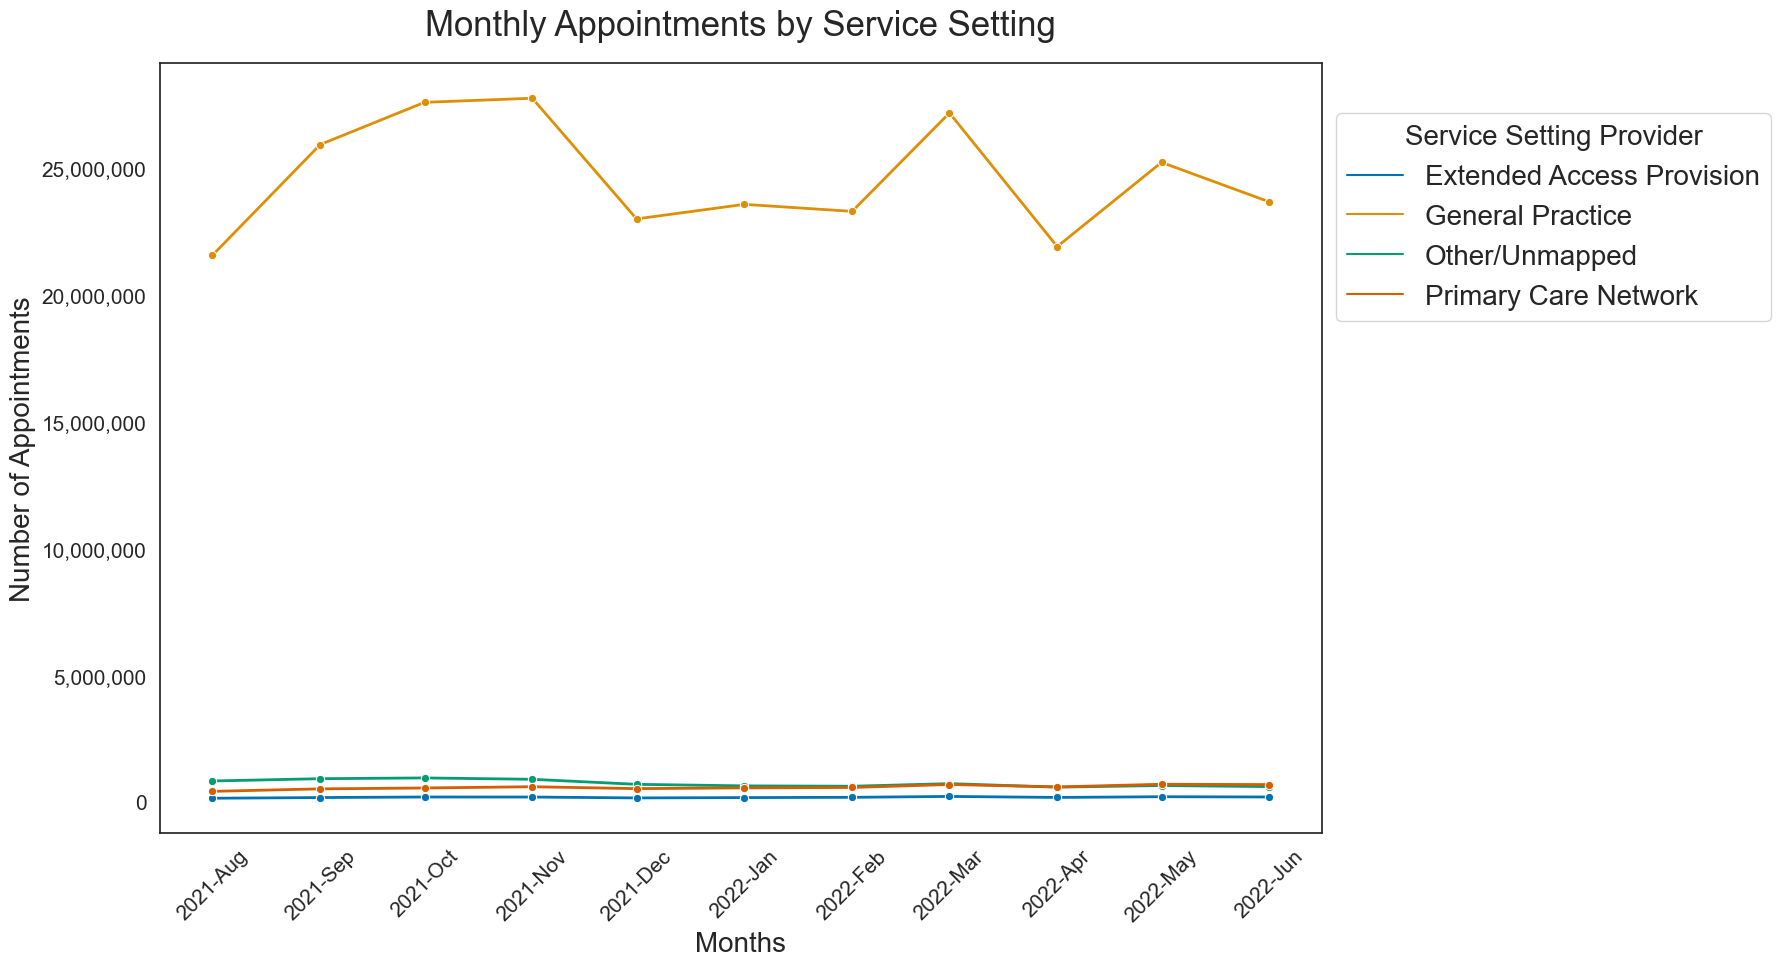

In [179]:
# Plot the appointments over the available date range, and review the service settings for months.
# Group Unmapped with others to ease visualisation
nc_ss = nc.groupby(['appointment_month','service_setting'])['count_of_appointments'].sum().reset_index()

nc_ss['service_setting'] = nc_ss['service_setting'].replace(['Other', 'Unmapped'], 'Other/Unmapped')


# size 
fig, ax = plt.subplots(figsize=(15, 10))

# Create a lineplot.
ax = sns.lineplot(x='appointment_month', y='count_of_appointments', data=nc_ss, hue='service_setting',
                  ci=None, palette='colorblind',linewidth='2',marker= 'o')

# Format x-axis labels
date_form = DateFormatter("%Y-%b")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_tick_params(rotation=45)
ax.tick_params(axis='x', labelsize=15)

# Format y-axis labels
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.tick_params(axis='y', labelsize=15)

# Set Title, axis labels, and legend
ax.set_title('Monthly Appointments by Service Setting', fontsize=25, pad=20)
ax.set_xlabel('Months', fontsize=20)
ax.set_ylabel('Number of Appointments', fontsize=20)
ax.legend(title='Service Setting Provider', bbox_to_anchor=(1, 0.8), loc='center left', fontsize = 20, title_fontsize =20)

# Show the plot
plt.show()

**Context types:**

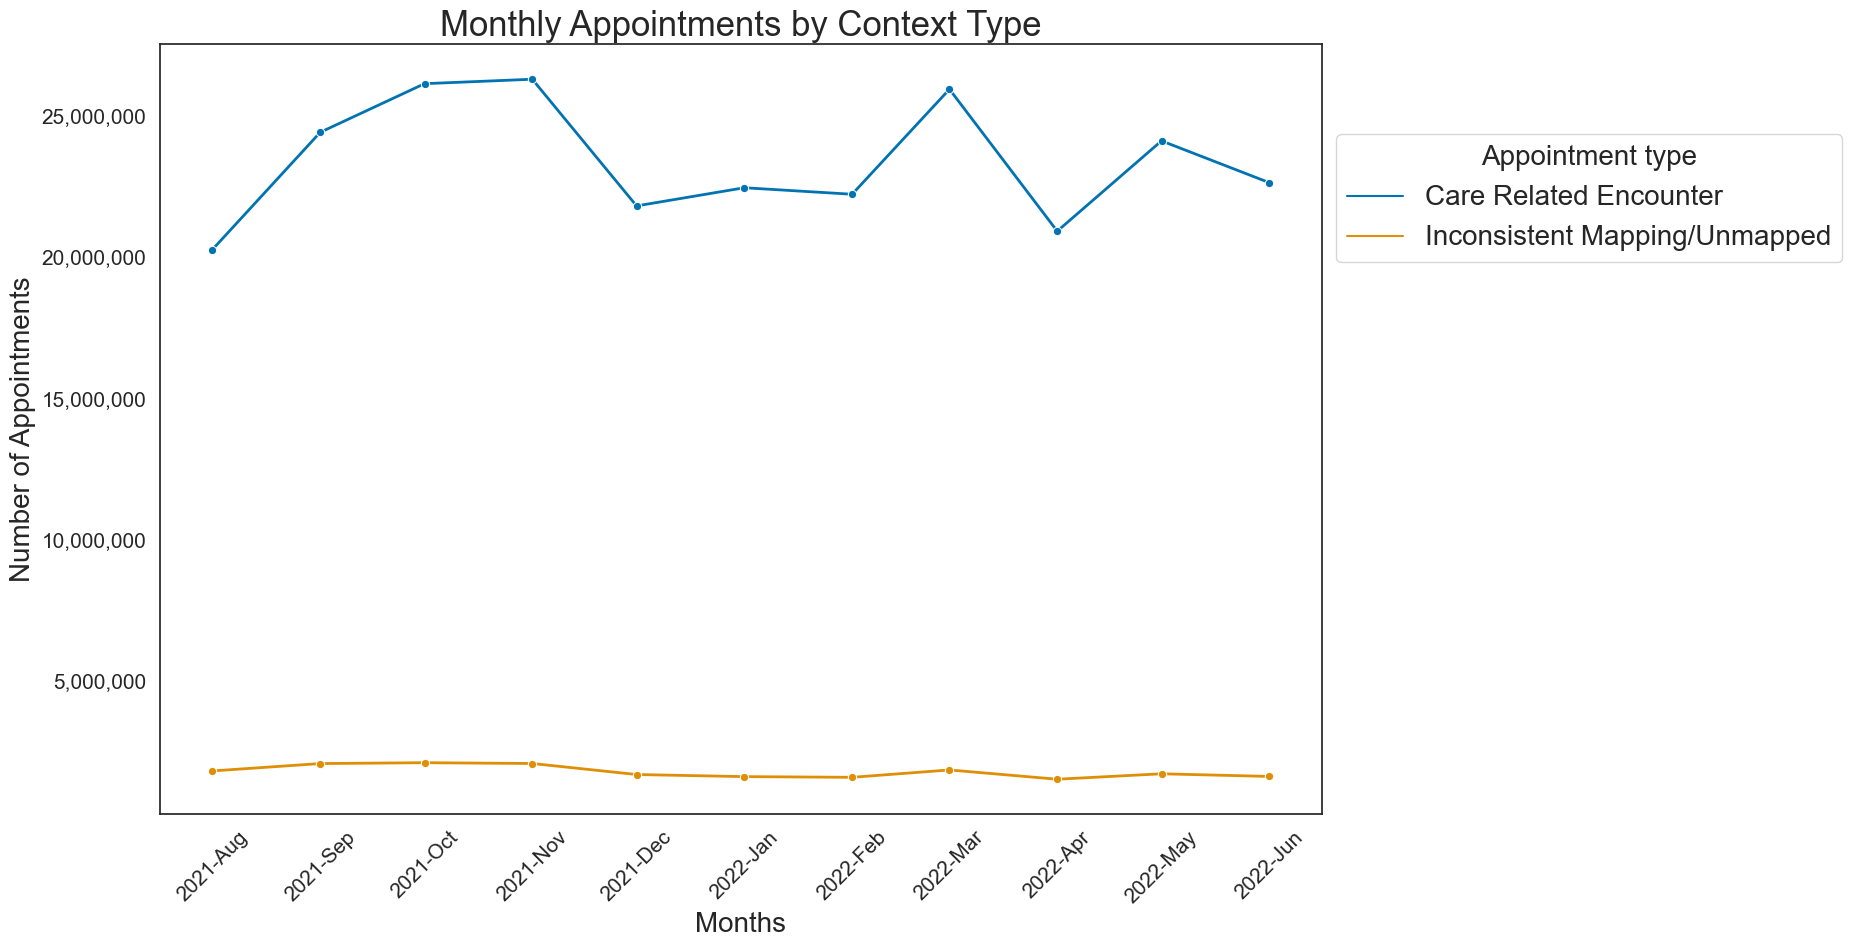

In [180]:
# Grouping the data
nc_ct1 = group2_apply_operation(nc, 'appointment_month', 'context_type', 'count_of_appointments', sum)

# Group 'Inconsistent Mapping' and 'Unmapped' for visualization
nc_ct1['context_type'] = nc_ct1['context_type'].replace(['Inconsistent Mapping', 'Unmapped'], 'Inconsistent Mapping/Unmapped')


# Create and format the plot
fig, ax = plt.subplots(figsize=(15, 10))

# Create the lineplot
sns.lineplot(x='appointment_month', y='count_of_appointments', data=nc_ct1, hue='context_type', ci=None,
             palette='colorblind', marker='o', linewidth=2, ax=ax)

# Set Title, formats, labels, and legend
ax.set_title('Monthly Appointments by Context Type', fontsize=25)
ax.set_xlabel('Months', fontsize=20)
ax.set_ylabel('Number of Appointments', fontsize=20)
date_form = DateFormatter("%Y-%b")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_tick_params(rotation=45, labelsize=15)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.tick_params(axis='y', labelsize=15)
ax.legend(title='Appointment type', bbox_to_anchor=(1, 0.8), loc='center left', fontsize=20, title_fontsize=20)


**National categories:**

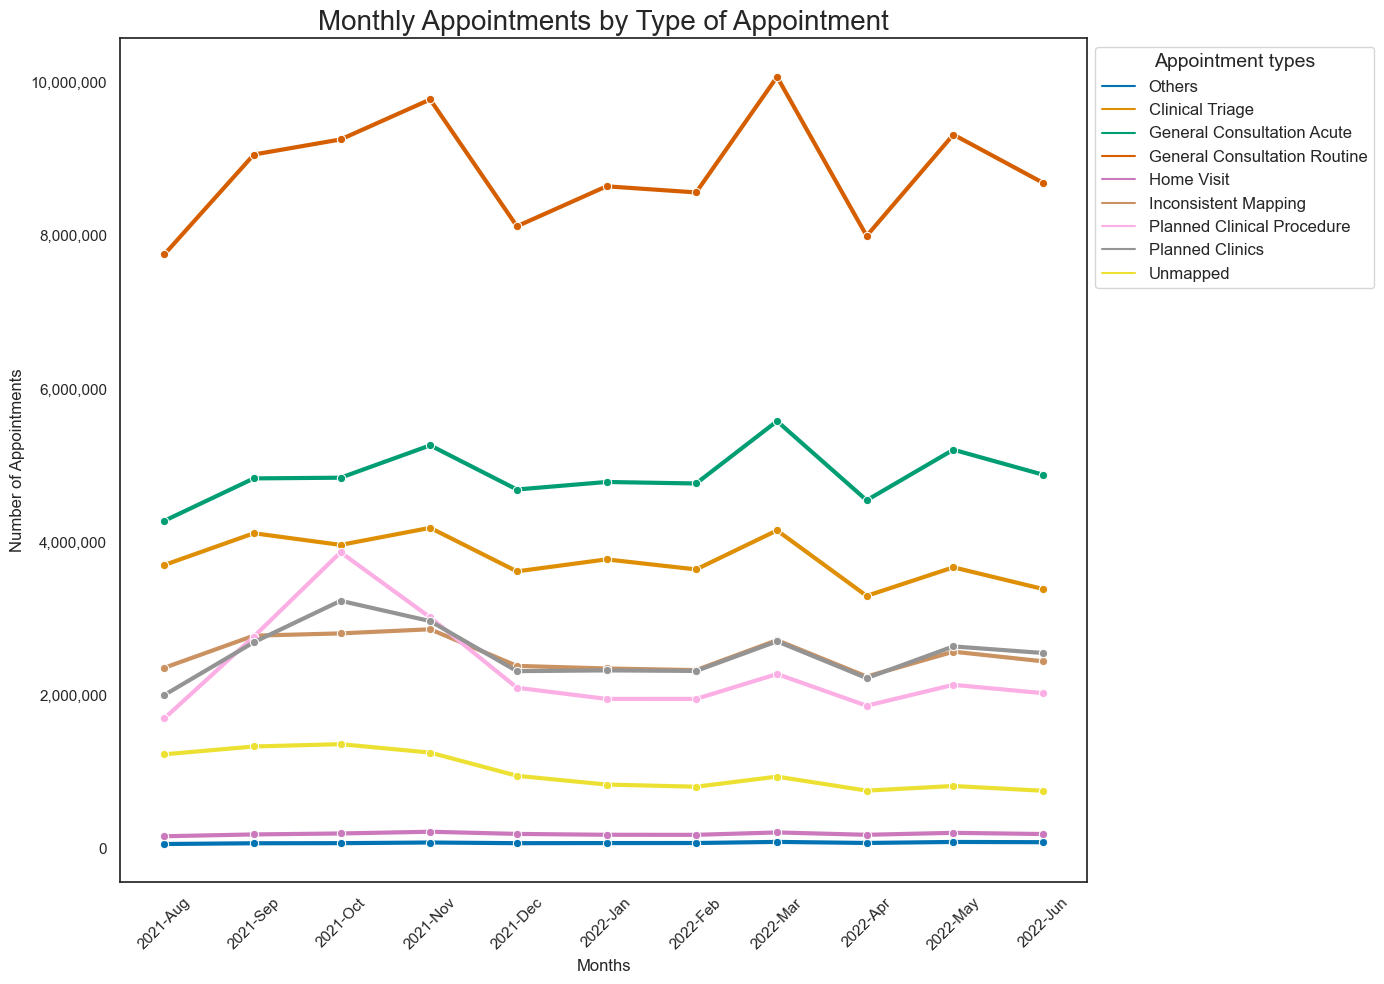

In [181]:
# Group by
nc_nc1 = group2_apply_operation(nc, 'appointment_month', 'national_category', 'count_of_appointments', sum)

# Group Unplanned Clinical Activity, Home Visits, Structured Medication Review to aid visualization
nc_nc1['national_category'] = nc_nc1['national_category'].replace(
    ['Unplanned Clinical Activity', 'Home Visits', 'Structured Medication Review',
     'Service provided by organisation external to the practice', 'Patient contact during Care Home Round',
     'Care Home Visit', 'Social Prescribing Service', 'Walk-in',
     'Care Home Needs Assessment & Personalised Care and Support Planning',
     'Non-contractual chargeable work', 'Group Consultation and Group Education'], 'Others')
    
# Create a line plot
plt.figure(figsize=(14, 10))
ax = sns.lineplot(x='appointment_month', y='count_of_appointments', data=nc_nc1, hue='national_category',
                  ci=None, palette='colorblind', marker='o', linewidth=3)

# Set Title, axis, and labels title
ax.set_title('Monthly Appointments by Type of Appointment', fontsize=20)
ax.set_xlabel('Months')
ax.set_ylabel('Number of Appointments')

# Format x-axis labels
date_form = DateFormatter("%Y-%b")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_tick_params(rotation=45)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# Adjust the legend to be outside the plot
ax.legend(title='Appointment types', bbox_to_anchor=(1, 1), loc='upper left', fontsize=12, title_fontsize=14)


plt.tight_layout()
plt.show()


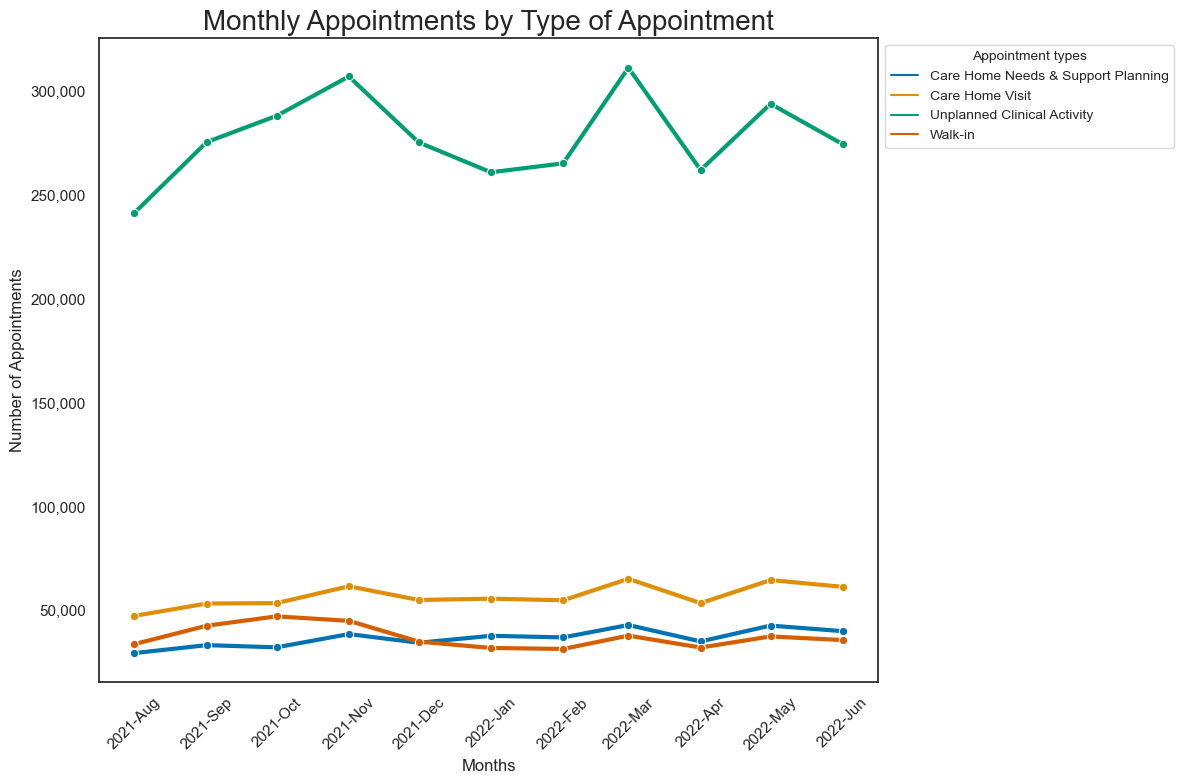

In [182]:
# Trend of Appointment type filtered out from previous analysis 
nc_nc2 = group2_apply_operation(nc, 'appointment_month', 'national_category', 'count_of_appointments', sum)

selected_categories = ['Walk-in', 'Unplanned Clinical Activity', 
                       'Care Home Needs Assessment & Personalised Care and Support Planning', 'Care Home Visit']

nc_nc2_filtered = nc_nc2[nc_nc2['national_category'].isin(selected_categories)]

# Rewrite Care Home Needs Assessment & Personalised Care and Support Planning to aid legend visualisation
nc_nc2_filtered['national_category'] = nc_nc2_filtered['national_category'].replace({
    'Care Home Needs Assessment & Personalised Care and Support Planning': 'Care Home Needs & Support Planning'
})

ax = sns.lineplot(x='appointment_month', y='count_of_appointments', data=nc_nc2_filtered, hue='national_category',
                  ci=None, palette='colorblind', marker='o', linewidth=3)

# Set Title, axis, and labels title
ax.set_title('Monthly Appointments by Type of Appointment', fontsize=20)
ax.set_xlabel('Months')
ax.set_ylabel('Number of Appointments')

# Format x-axis labels
date_form = DateFormatter("%Y-%b")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_tick_params(rotation=45)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# Adjust the legend to be outside the plot
ax.legend(title='Appointment types', bbox_to_anchor=(1, 1), loc='upper left', fontsize=10, title_fontsize=10)


plt.tight_layout()
plt.show()


Overall most of the appointemnt types have increased with the exeception of clinical triage. This might suggest that patients have better access to routine and preventive care, reducing the need for urgent assessment. On the other hand,patients might perceive hospitals a better option.

seasonal Variation: Not all appointment types follow a seasonal pattern. This is likely because some types of appointments (such as planned procedures) require prior planning and scheduling, which can disrupt seasonal trends.

Next, we are going to see this in more detail by further refining the analysis by season.

### Check of seasonal trends. 

We will first check appointments by service setting, and then we will specifically look at GP appointments.

**Summer:** No enough data to evaluate trend closely by service setting. We will use the AR df instead to infer conclusions by gp practice

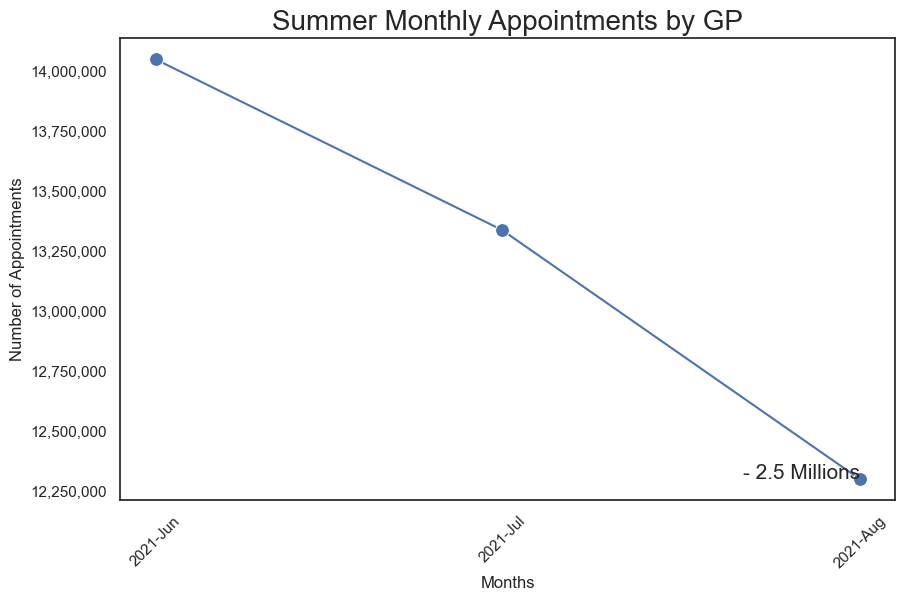

In [226]:
# Filter summer and GP data and group by appointment. 
ar_summer = ar[(ar['appointment_month'] >= '2021-06-01') & 
               (ar['appointment_month'] <= '2021-08-01') & 
               (ar['hcp_type'] == 'GP')]

# Group by appointment month and HCP type, then sum the count of appointments
ar_summer_grouped = ar_summer.groupby(['appointment_month', 'hcp_type']).agg({'count_of_appointments': 'sum'}).reset_index()

# Display the grouped data
ar_summer_grouped

# Plot 
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.lineplot(x='appointment_month', y='count_of_appointments', data=ar_summer_grouped, marker='o', markersize=10)
ax.set_title('Summer Monthly Appointments by GP', fontsize=20)
ax.set_xlabel('Months')
ax.set_ylabel('Number of Appointments')

# Format the x-axis to show dates 
# Set date range, rotate to aid visualisation
date_range = pd.date_range(start=ar_summer['appointment_month'].min(), end=ar_summer['appointment_month'].max(), freq='MS')

# Format x-axis tick labels
ax.set_xticks(date_range)
ax.set_xticklabels(date_range.strftime('%Y-%b'), rotation=45)

# Format the y-axis to show commas in numbers
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# Add annotation
plt.text(ar_summer_grouped['appointment_month'].iloc[-1], ar_summer_grouped['count_of_appointments'].iloc[-1],
         '- 2.5 Millions', ha='right', fontsize=15)

# View
plt.show()

We can observe an inflection of about 2.5 million appointments

**Autumn:**

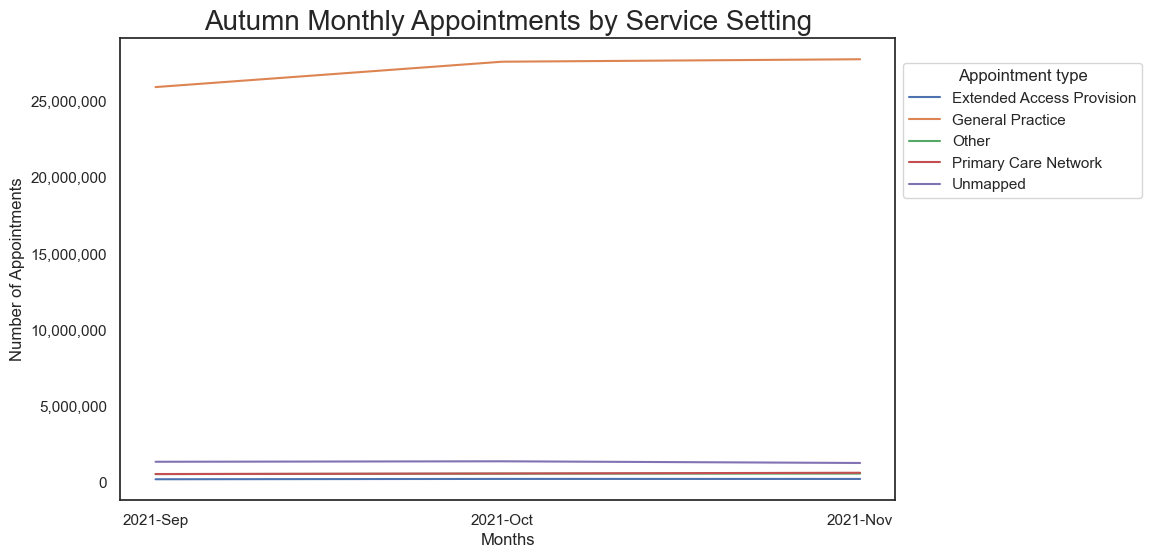

In [184]:
# Create a separate data set that can be used in future weeks. September to November 2021)
nc_autumn= nc[(nc['appointment_month'] >= '2021-09-01')& (nc['appointment_month'] <= '2021-11-30')]

autumnapp_by_ss = nc_autumn.groupby(['appointment_month','service_setting'])['count_of_appointments'].sum().reset_index()
autumnapp_by_ss

# Visualise the subset using a lineplot.
fig, ax = plt.subplots(figsize=(10, 6))
ax =sns.lineplot(x='appointment_month', y='count_of_appointments',hue='service_setting',data=autumnapp_by_ss)

# Set Title, axis, and labels title
ax.set_title('Autumn Monthly Appointments by Service Setting',fontsize=20)
ax.set_xlabel('Months')
ax.set_ylabel('Number of Appointments')


# Format the x-axis to show dates 
# Set date range, rotate to aid visualisation
date_range = pd.date_range(start=autumnapp_by_ss['appointment_month'].min(), end=autumnapp_by_ss['appointment_month'].max(), freq='MS')

# Format x-axis tick labels
ax.set_xticks(date_range)
ax.set_xticklabels(date_range.strftime('%Y-%b'))

ax.legend(title='Appointment type', bbox_to_anchor=(1, 0.8), loc='center left')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))



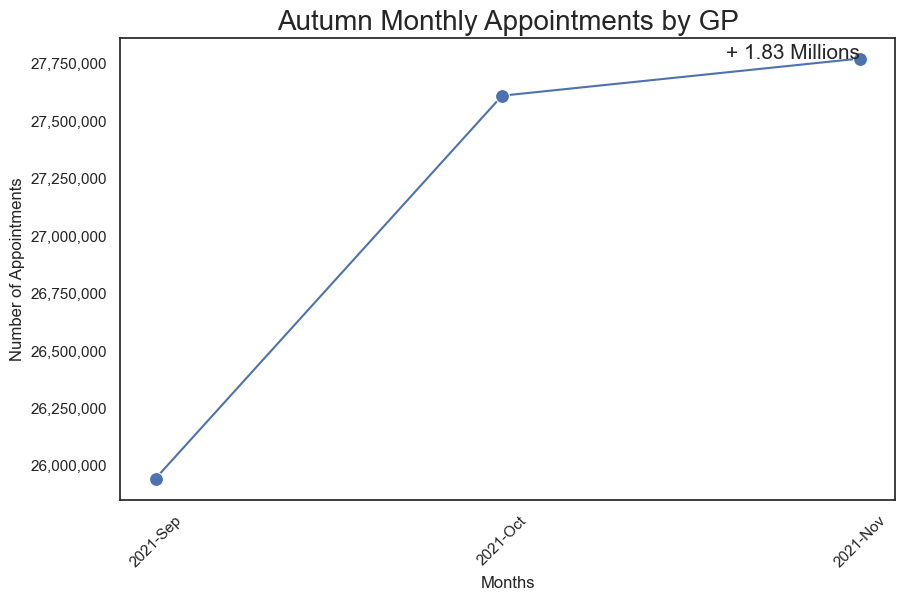

In [185]:
nc_autumn_gp = nc_autumn[(nc_autumn['service_setting'] == 'General Practice')]

# Group by 
nc_autumn_gp = nc_autumn_gp.groupby('appointment_month')['count_of_appointments'].sum().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
ax = sns.lineplot(x='appointment_month', y='count_of_appointments', data=nc_autumn_gp, ci=None, marker='o', 
                 markersize=10)

# Setting Title, axis labels, and formatting
ax.set_title('Autumn Monthly Appointments by GP', fontsize=20)
ax.set_xlabel('Months')
ax.set_ylabel('Number of Appointments')


# Format the x-axis to show dates 
# Set date range, rotate to aid visualisation
date_range = pd.date_range(start=nc_autumn_gp['appointment_month'].min(), end=nc_autumn_gp['appointment_month'].max(), freq='MS')

# Format x-axis tick labels
ax.set_xticks(date_range)
ax.set_xticklabels(date_range.strftime('%Y-%b'), rotation=45)

#Format y label to display number in millions 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# Add annotation
plt.text(nc_autumn_gp['appointment_month'].iloc[-1], nc_autumn_gp['count_of_appointments'].iloc[-1],
         '+ 1.83 Millions', ha='right', fontsize=15)

# Show the plot
plt.show()


**Winter:**

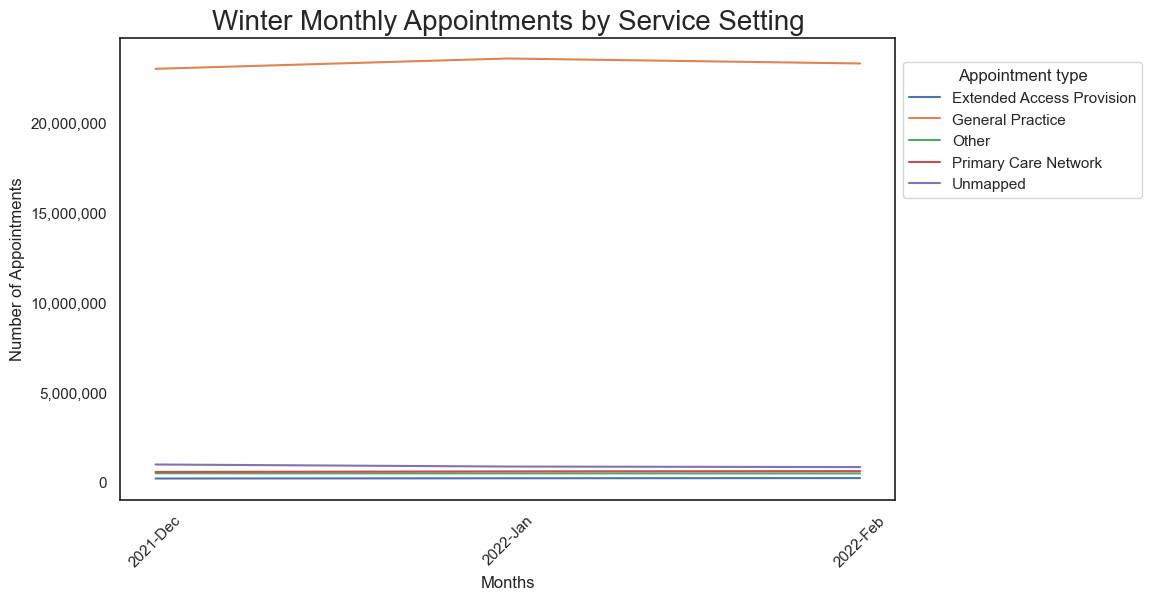

In [186]:
# (December to February 2022)
winterapp_by_ss = nc[(nc['appointment_month'] >= '2021-12-01')& (nc['appointment_month'] <= '2022-02-01')]

#Group by
winterapp_by_ss = group2_apply_operation(winterapp_by_ss,'appointment_month','service_setting','count_of_appointments',sum) 

# Visualise the subset using a lineplot.
fig, ax = plt.subplots(figsize=(10, 6))
ax= sns.lineplot(x='appointment_month', y='count_of_appointments',hue='service_setting',data=winterapp_by_ss)

# Set Title, axis, and labels title
ax.set_title('Winter Monthly Appointments by Service Setting',fontsize=20)
ax.set_xlabel('Months')
ax.set_ylabel('Number of Appointments')

# Format the x-axis to show dates 
# Set date range, rotate to aid visualisation
date_range = pd.date_range(start=winterapp_by_ss['appointment_month'].min(), end=winterapp_by_ss['appointment_month'].max(), freq='MS')

# Format x-axis tick labels
ax.set_xticks(date_range)
ax.set_xticklabels(date_range.strftime('%Y-%b'), rotation=45)

#Format y label to display number in millions 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# Format Legend 
ax.legend(title='Appointment type', bbox_to_anchor=(1, 0.8), loc='center left')


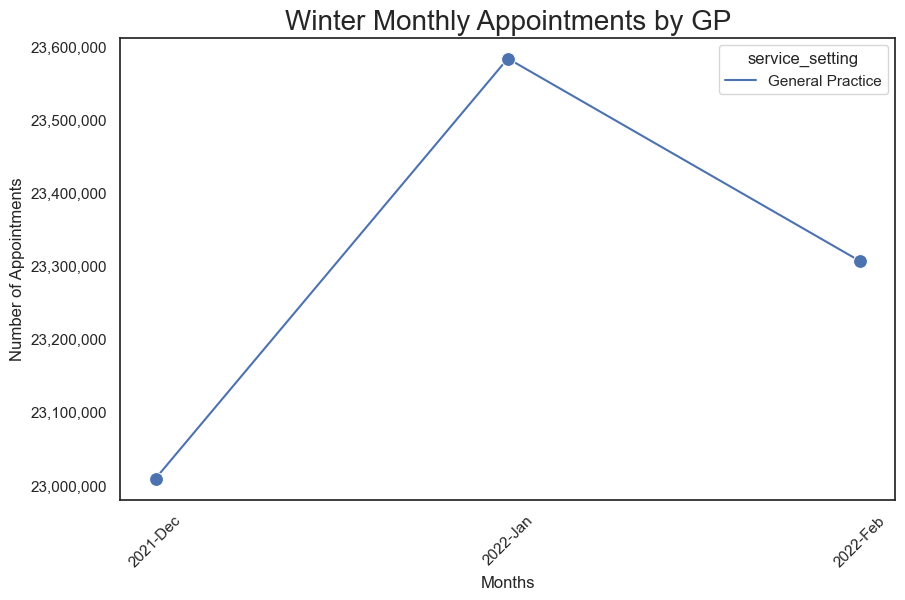

In [227]:
# Check GP only to highlight trends
nc_winter_gp = winterapp_by_ss[winterapp_by_ss['service_setting'] == 'General Practice']

#Group by 
nc_winter_gp = group2_apply_operation(nc_winter_gp,'appointment_month','service_setting', 'count_of_appointments',sum)

#Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax= sns.lineplot(x='appointment_month', y='count_of_appointments',hue='service_setting',
                 data=nc_winter_gp, marker='o',markersize=10)

#Set Title, axis, and labels title
ax.set_title('Winter Monthly Appointments by GP',fontsize=20)
ax.set_xlabel('Months')
ax.set_ylabel('Number of Appointments')

# Format the x-axis to show dates 
# Set date range, rotate to aid visualisation
date_range = pd.date_range(start=winterapp_by_ss['appointment_month'].min(), end=winterapp_by_ss['appointment_month'].max(), freq='MS')

# Format x-axis tick labels
ax.set_xticks(date_range)
ax.set_xticklabels(date_range.strftime('%Y-%b'), rotation=45)

#Format y label to display number in millions 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))


+600k in january and + 300k in February

**Spring:**

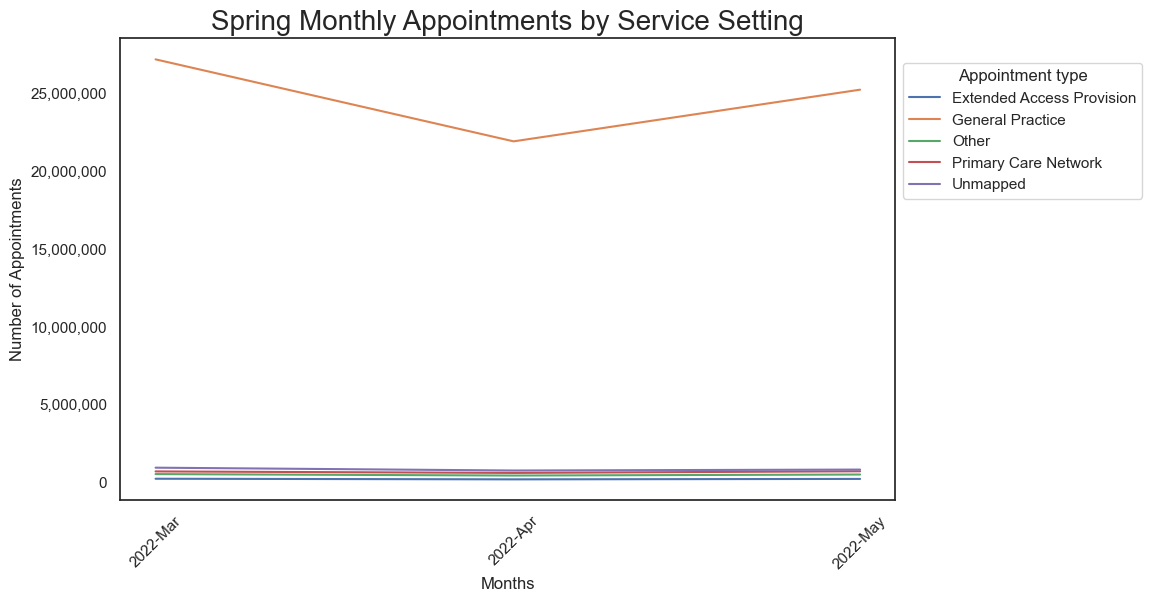

In [188]:
# Create a Spring subset March to May 2022
nc_spring = nc[(nc['appointment_month'] >= '2022-03-01')& (nc['appointment_month'] <= '2022-05-01')]

springapp_by_ss = nc_spring.groupby(['appointment_month','service_setting'])['count_of_appointments'].sum().reset_index()
springapp_by_ss

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax= sns.lineplot(x='appointment_month', y='count_of_appointments',hue='service_setting',data=springapp_by_ss) 

# Set Title, axis, and labels title
ax.set_title('Spring Monthly Appointments by Service Setting',fontsize=20)
ax.set_xlabel('Months')
ax.set_ylabel('Number of Appointments')

# Format the x-axis to show dates 
# Set date range, rotate to aid visualisation
date_range = pd.date_range(start=springapp_by_ss['appointment_month'].min(), end=springapp_by_ss['appointment_month'].max(), freq='MS')

# Format x-axis tick labels
ax.set_xticks(date_range)
ax.set_xticklabels(date_range.strftime('%Y-%b'), rotation=45)

#Format y label to display number in millions 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# Format Legend
ax.legend(title='Appointment type', bbox_to_anchor=(1, 0.8), loc='center left')



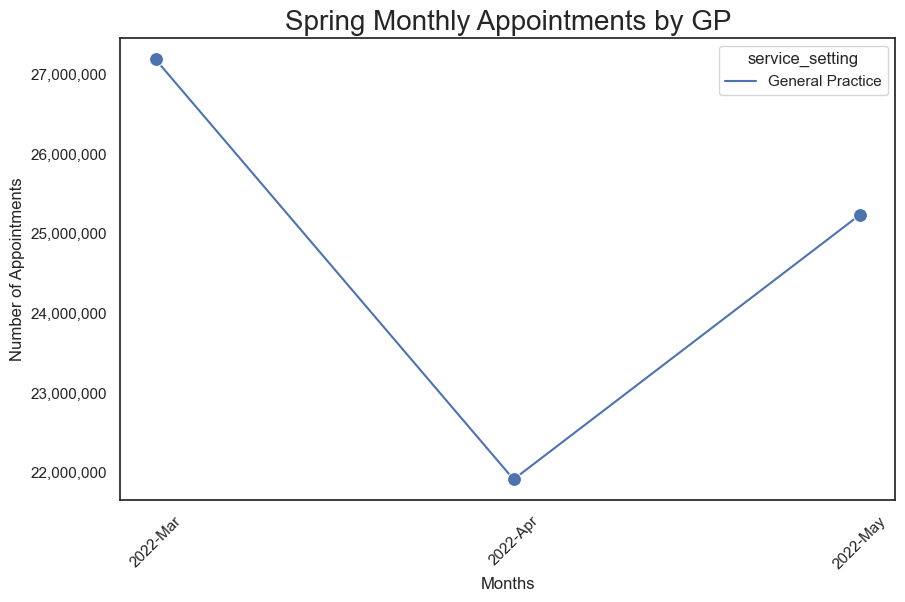

In [228]:
# Visualise the subset for General Practices
nc_spring_gp = nc_spring[nc_spring['service_setting'] == 'General Practice']

#Group by 
nc_spring_gp = group2_apply_operation(nc_spring_gp,'appointment_month','service_setting', 'count_of_appointments',sum)

#Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax= sns.lineplot(x='appointment_month', y='count_of_appointments',hue='service_setting',data=nc_spring_gp, marker='o', markersize=10)


#Set Title, axis, and labels title
ax.set_title('Spring Monthly Appointments by GP',fontsize=20)
ax.set_xlabel('Months')
ax.set_ylabel('Number of Appointments')

# Format the x-axis to show dates 
# Set date range, rotate to aid visualisation
date_range = pd.date_range(start=nc_spring_gp['appointment_month'].min(), end=nc_spring_gp['appointment_month'].max(), freq='MS')

# Format x-axis tick labels
ax.set_xticks(date_range)
ax.set_xticklabels(date_range.strftime('%Y-%b'), rotation=45)

#Format y label to display number in millions 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))


-5.3 millions in April. Overall descrease of about 300k during the spring period. 

## Investigate the main concerns raised by the NHS. 

For analysis of trends we will consider the full year (June 2021- June 2022). 
This will allow us to make comparisons and capture trends of seasonal variations due to holidays, school closures etc. 

Moroever, this will allows us to align more closely with the records of the nc dataset.

In [190]:
# Filter the data set to only look at data from 2021-06 onwards.
ar_june_2021_onwards = ar[ar['appointment_month']>= '2021-06-01']

# Check outpout
print(ar_june_2021_onwards.head())

# Create an aggregated data set to review the different features.
#Create subset with column of interest  
ar_sub = ar_june_2021_onwards[['appointment_month', 'hcp_type', 'appointment_status', 'appointment_mode','time_between_book_and_appointment', 'count_of_appointments']]

#Use the groupby() function
ar_sub_grouped = ar_sub.groupby(['appointment_month', 'hcp_type', 'appointment_status', 'appointment_mode','time_between_book_and_appointment'])['count_of_appointments'].sum().reset_index()

# Determine the total number of appointments per month: June 2021 onwards.
ar_df= group1_apply_operation(ar_sub_grouped,'appointment_month','count_of_appointments',sum)

print(ar_df)

     icb_ons_code appointment_month appointment_status hcp_type  \
5144    E54000008        2021-06-01           Attended       GP   
5145    E54000008        2021-06-01           Attended       GP   
5146    E54000008        2021-06-01           Attended       GP   
5147    E54000008        2021-06-01           Attended       GP   
5148    E54000008        2021-06-01           Attended       GP   

     appointment_mode time_between_book_and_appointment  count_of_appointments  
5144     Face-to-Face                             1 Day                  35538  
5145     Face-to-Face                    15  to 21 Days                   7016  
5146     Face-to-Face                       2 to 7 Days                  54293  
5147     Face-to-Face                    22  to 28 Days                   3222  
5148     Face-to-Face                     8  to 14 Days                  17861  
   appointment_month  count_of_appointments
0         2021-06-01               26784182
1         2021-07-01   

### Determining needs of increasing Staff Capacity

**The NHS has provided a figure of an average of 1,200,000 appointments per day being used for planning purposes, which can be used as a  guideline for maximum capacity**.

For simplicity, we will calculate the optimal target by dividing appointment_month/ the average estimated optimal utilization (1,200,000) for the weekdays of each month. This will provide an estimate of the daily or monthly target utilization.

In [191]:
# Calculate weekdays in each month  using np.busday_count
ar_df['weekdays_by_month'] = ar_df['appointment_month'].\
apply(lambda date: np.busday_count(date.strftime('%Y-%m'), (date + pd.DateOffset(months=1)).strftime('%Y-%m')))

# Calculate daily estimate by dividing total appointments by weekdays
ar_df['estimate_daily_appointements'] = (ar_df['count_of_appointments'] / ar_df['weekdays_by_month']).round(1)

# Define maximum capacity target by month
ar_df['optimal_capacity'] = ar_df['weekdays_by_month'] * 1200000

print(ar_df)

   appointment_month  count_of_appointments  weekdays_by_month  \
0         2021-06-01               26784182                 22   
1         2021-07-01               25739219                 22   
2         2021-08-01               23852171                 22   
3         2021-09-01               28522501                 22   
4         2021-10-01               30303834                 21   
5         2021-11-01               30405070                 22   
6         2021-12-01               25140776                 23   
7         2022-01-01               25635474                 21   
8         2022-02-01               25355260                 20   
9         2022-03-01               29595038                 23   
10        2022-04-01               23913060                 21   
11        2022-05-01               27495508                 22   
12        2022-06-01               25828078                 22   

    estimate_daily_appointements  optimal_capacity  
0                     

**Appointment Trends over time (June 2021-June 2022)**

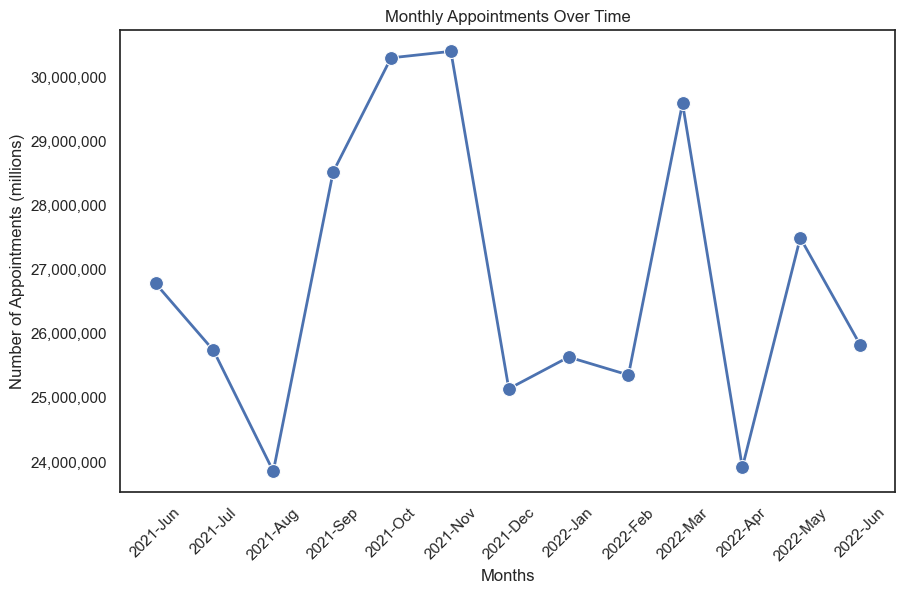

In [229]:
# Plot sum of count of monthly visits.
# Set size of the plot
plt.figure(figsize=(10, 6))

# Create linep plot 
ax = sns.lineplot(x='appointment_month', y='count_of_appointments', data = ar_df, marker='o', ci=None, linewidth = 2,  markersize=10)

# Set Title and labels
ax.set_title('Monthly Appointments Over Time')
ax.set_xlabel('Months')
ax.set_ylabel('Number of Appointments (millions)')

# Set x-axis tick labels, transform appointment_mont to string data type for ease of visualization.
date_range = pd.date_range(start=ar_df['appointment_month'].min(), end=ar_df['appointment_month'].max(), freq='MS')

# Format x-axis tick labels
ax.set_xticks(date_range)
ax.set_xticklabels(date_range.strftime('%Y-%b'), rotation=45)

#Format y label to display number in millions 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))


# Show plot
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


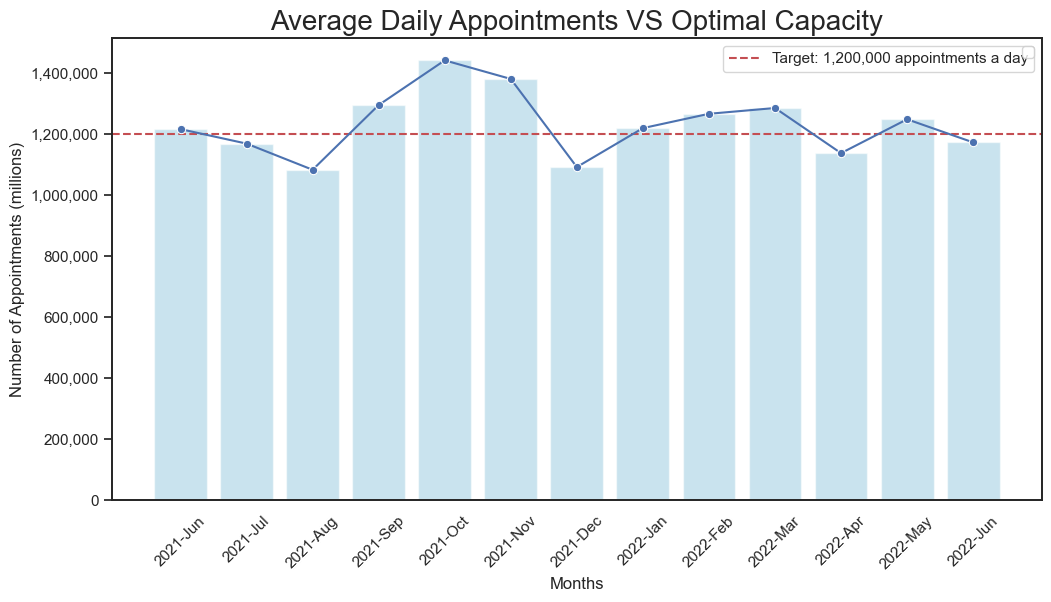

In [193]:
# Create figure and axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Create the bar plot on ax2
ax2 = sns.barplot(x='appointment_month', y='estimate_daily_appointements', data=ar_df, color='skyblue', alpha=0.5, ax=ax1)

# Set x-axis tick labels, transform appointment_month2 to string data type for ease of visualization.
ax2.set_xticklabels(ar_df['appointment_month'].dt.strftime('%Y-%b'), rotation=45)

# Set Title and labels
ax2.set_title('Average Daily Appointments VS Optimal Capacity',fontsize=20)
ax2.set_xlabel('Months')
ax2.set_ylabel('Number of Appointments (millions)')

# Add a horizontal line for the target on ax2
ax2.axhline(y=1200000, color='r', linestyle='--', label='Target: 1,200,000 appointments a day')

# Create the line plot on ax1
sns.lineplot(data=ar_df['estimate_daily_appointements'], marker='o', sort=False, ax=ax1)

# Create a twin Axes sharing the same x-axis with ax1
ax3 = ax1.twinx()

# Hide tick marks on the right side
ax3.set_yticks([])

# Format y-axis tick labels
ax1.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# Show legend and plot
plt.legend()
plt.show()

The average estimate of daily appointments has mostly met the daily targets on a monthly basis, with occasional dips due to seasonal variations.

October–November 2021 and March 2022 were months when capacity was higher compared to other periods. However, the total number of appointments in June 2021 shows a decline, which is particularly concerning given that this period corresponds to the COVID-19 pandemic.

**Trend of appointemnt by healthcare professional over time**

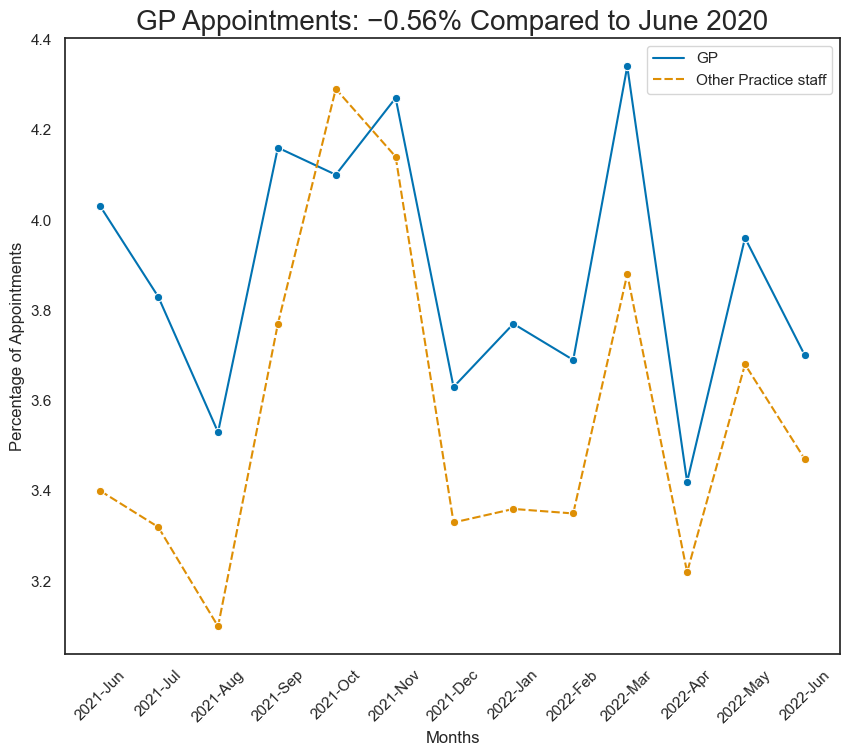

In [194]:
# View the DataFrame  
ar_hcp = group2_apply_operation(ar_june_2021_onwards,'appointment_month','hcp_type','count_of_appointments',sum)

#Calculate %
ar_hcp['Percentage']=((ar_hcp['count_of_appointments']/ar_hcp['count_of_appointments'].sum())*100).round(2)

# Filter out Unknow data to aid visualisation.
ar_hcp_filtered = ar_hcp[ar_hcp['hcp_type'] != 'Unknown']

# Create a lineplot to display trend of appointments by healthcare professional
# Set size of the plot
plt.figure(figsize=(10, 8))


ax = sns.lineplot(x='appointment_month', y='Percentage', hue='hcp_type'\
                  , data=ar_hcp_filtered, palette='colorblind', marker='o', style='hcp_type')

# Set Title and labels
ax.set_title('GP Appointments: −0.56% Compared to June 2020',fontsize=20)
ax.set_xlabel('Months')
ax.set_ylabel('Percentage of Appointments')

# Set x-axis tick labels, transform appointment_mont to string data type for ease of visualization.
date_range = pd.date_range(start=str(ar_hcp['appointment_month'].min()), end=str(ar_hcp['appointment_month'].max()), freq='MS')

# Format x-axis tick labels
ax.set_xticks(date_range)
ax.set_xticklabels(date_range.strftime('%Y-%b'), rotation=45)

# Show plot with legend
plt.legend()
plt.show()


**Overall Trend:**

Decrease in number of appointments comapared to last year has been not consistent across all health specialist. GP practices have lost the 0,56 % which transalte in almost a million appointments since June 2021, which might indicate strains for GP to cope with the demand. 


## Investigate Missed appointments 

Next we will look at DNAs.

Missed appointment is a key measure for health services to track patient pathways and service utilisation.We will check their trend over time. 


**Trends of Missed Appointments**

We will first look at the absolute number of appointements. 

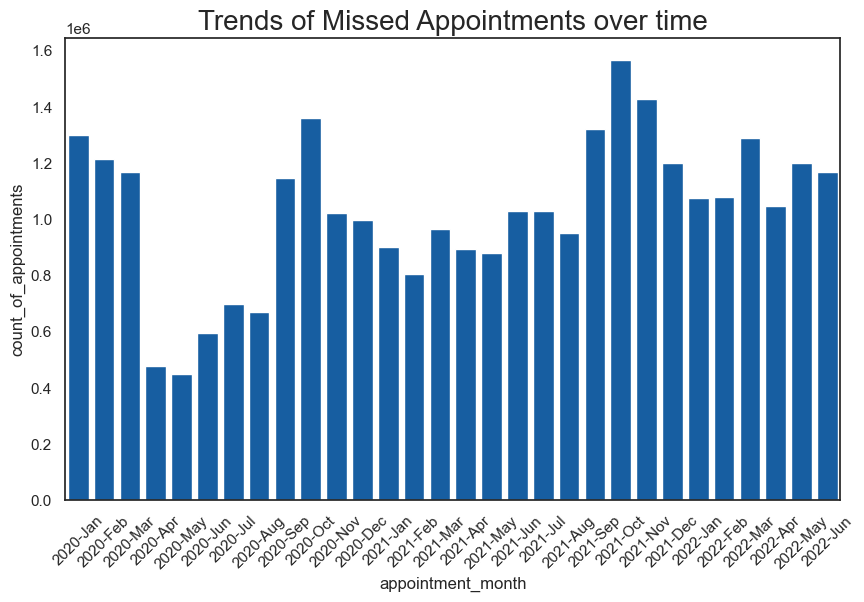

<Figure size 600x600 with 0 Axes>

In [231]:
# Set size of the plot
plt.figure(figsize=(10, 6))

# Create a lineplot with row count of appointments
ar_status_trend = ar.groupby(['appointment_month','appointment_status'])['count_of_appointments'].sum().reset_index()

# Filter appointment status
ar_dna_trend = ar_status_trend[ar_status_trend['appointment_status'] == 'DNA']

# Create bar plot
ax = sns.barplot(x='appointment_month', y='count_of_appointments', data=ar_dna_trend, color = '#005EB8')
ax.set_title('Trends of Missed Appointments over time',fontsize=20)


# Set x-axis tick labels, transform appointment_month2 to string data type for ease of visualization
ax.set_xticklabels(ar_dna_trend['appointment_month'].dt.strftime('%Y-%b'), rotation=45)

# Show the plot
plt.show()
plt.tight_layout()

Excluding the COVID outbreak period, which inevitably skews the analysis, the number of missed appointments has increased over time. This increase is concerning, especially given that lockdown measures were lifted in June 2021.

https://www.instituteforgovernment.org.uk/sites/default/files/2022-12/timeline-coronavirus-lockdown-december-2021.pdf


**Relative number of DNA over time** 

AttributeError: 'Axes' object has no attribute 'plt'

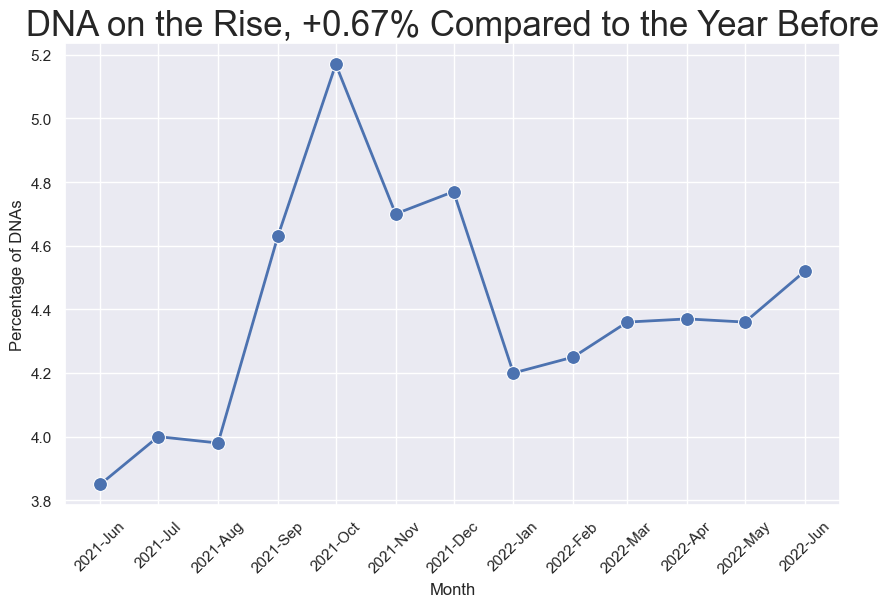

In [308]:
# Define total appointments by month
total_app_by_month = ar_june_2021_onwards.groupby('appointment_month')['count_of_appointments'].sum()

# Define DNAs by month
dna_by_month = ar_june_2021_onwards[ar_june_2021_onwards['appointment_status'] == 'DNA'].groupby('appointment_month')['count_of_appointments'].sum()

# Calculate the percentage of DNAs by month
percentage_dna_by_month = ((dna_by_month / total_app_by_month) * 100).round(2)

# Plot the series
fig, ax = plt.subplots(figsize=(10, 6))

# Create a line plot
ax = sns.lineplot(data=percentage_dna_by_month, marker='o', linestyle='-', linewidth=2 , markersize = 10)
ax.set_xlabel('Month')
ax.set_ylabel('Percentage of DNAs')
ax.set_title('DNA on the Rise, +0.67% Compared to the Year Before', fontsize=25)

# Set date range for the x-axis
date_range = pd.date_range(start=percentage_dna_by_month.index.min(), end=percentage_dna_by_month.index.max(), freq='MS')

# Format x-axis tick labels
ax.set_xticks(date_range)
ax.set_xticklabels(date_range.strftime('%Y-%b'), rotation=45)

ax.plt.grid(False)

**Yearly Financial Impact of DNAs on Sub ICB Locations**

Each appointment costs an average of £30; therefore, the financial impact will be calculated by multiplying the number of appointments by 30.
https://www.england.nhs.uk/2019/01/missed-gp-appointments-costing-nhs-millions/ 


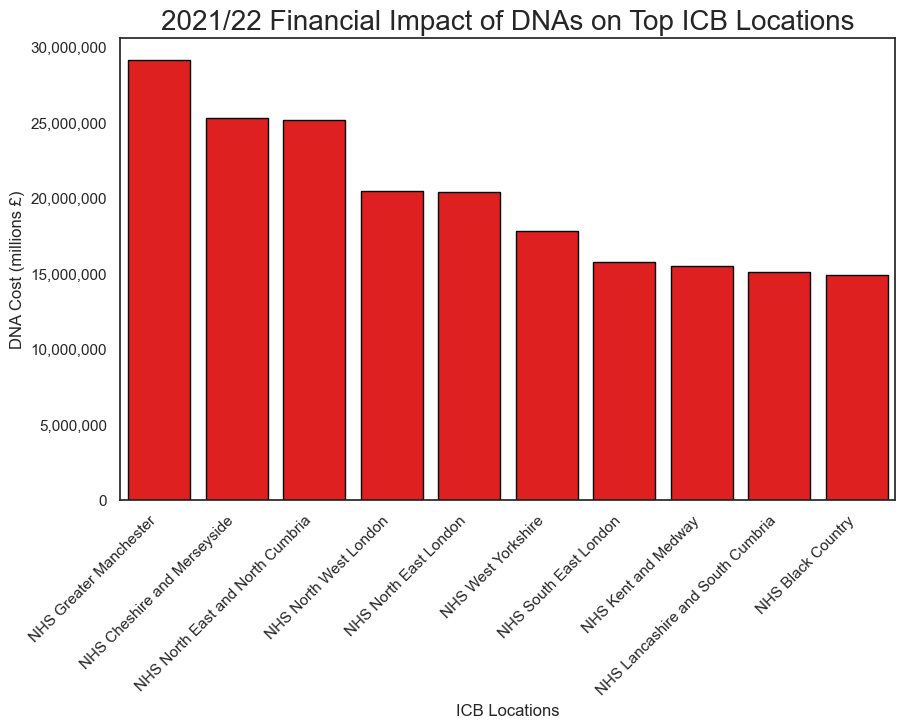

In [198]:
# Aggregate total appointemtns by status and icb locations
appointment_by_location = group_2variables_by_cnt_appointments(ar_june_2021_onwards,'icb_ons_code', 'appointment_status')

# Pivot the Df
appointment_by_location_pivot = appointment_by_location.pivot(index='icb_ons_code', columns='appointment_status', values='total_appointment')

# Reset index 
appointment_by_location_pivot.reset_index(inplace=True)

# Calculate total appointments 
appointment_by_location_pivot['total_appointment'] = appointment_by_location_pivot['Attended'] + appointment_by_location_pivot['DNA'] + appointment_by_location_pivot['Unknown']

# Calculate missed appointment rate by location
appointment_by_location_pivot['DNA_rate'] = ((appointment_by_location_pivot['DNA'] / appointment_by_location_pivot['total_appointment']) * 100).round(2)

# Calculate estimated cost per missed appointment (1 DNA = £30)
appointment_by_location_pivot['estimated_dna_cost'] = appointment_by_location_pivot['DNA'] * 30

# View the final output
appointment_by_location_pivot.sort_values(by='Unknown', ascending= False).head()


# Create plot to represent locations where costs are higher in absolute terms.  
# Merge loc_by_dna_cost with location_df to return corresponding name of icb_ons_code
loc_by_dna_cost_merged = pd.merge (location_df,appointment_by_location_pivot , on='icb_ons_code', how='left')

# View output and sort by costs. (top 10)
top_10_by_dna_cost= loc_by_dna_cost_merged.sort_values(by='estimated_dna_cost', ascending= False).head(10)

#Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.barplot(y='estimated_dna_cost', x='sub_icb_location', data=top_10_by_dna_cost, color='red', edgecolor = 'black')
# Set Title and Labels 
ax.set_title('2021/22 Financial Impact of DNAs on Top ICB Locations', size = 20)
ax.set_xlabel('ICB Locations')
ax.set_ylabel('DNA Cost (millions £)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Apply y-axis formatter
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))


# View Plot 
plt.show()

**High levels of DNAs by Sub ICB Locations**

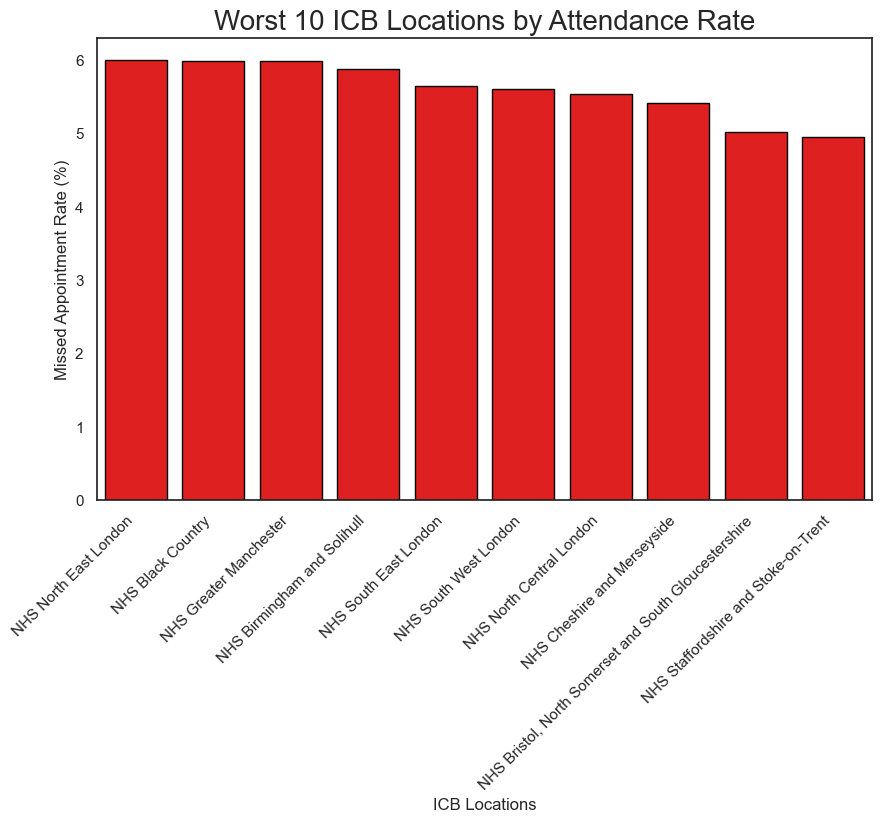

In [199]:

# Plot of the top 10 location by cost in proportion to the number of total appointments 

# Use merged df: loc_by_dna_cost_merged and sort by top 10 DNA rate
top_10_by_dna_rate= loc_by_dna_cost_merged.sort_values(by= 'DNA_rate', ascending= False).head(10)

# Plot 
#Create bar plot
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(y='DNA_rate', x='sub_icb_location', data=top_10_by_dna_rate, color='red', edgecolor = 'black')

# Set Title and Labels 
ax.set_title('Worst 10 ICB Locations by Attendance Rate', size = 20)
ax.set_xlabel('ICB Locations')
ax.set_ylabel('Missed Appointment Rate (%)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# View Plot 
plt.show()

In these locations, there may be underlying issues with service accessibility, such as inconvenient appointment times. Additionally, longer waiting times and inefficiencies in appointment management are factors that require further exploration.

**N.B. Serious data quality issues**: In some locations, the number of unknown appointments is equal to or greater than the number of missed appointments. This analysis could be significantly underestimated.



**Change in terms of appointment type and the busiest months**

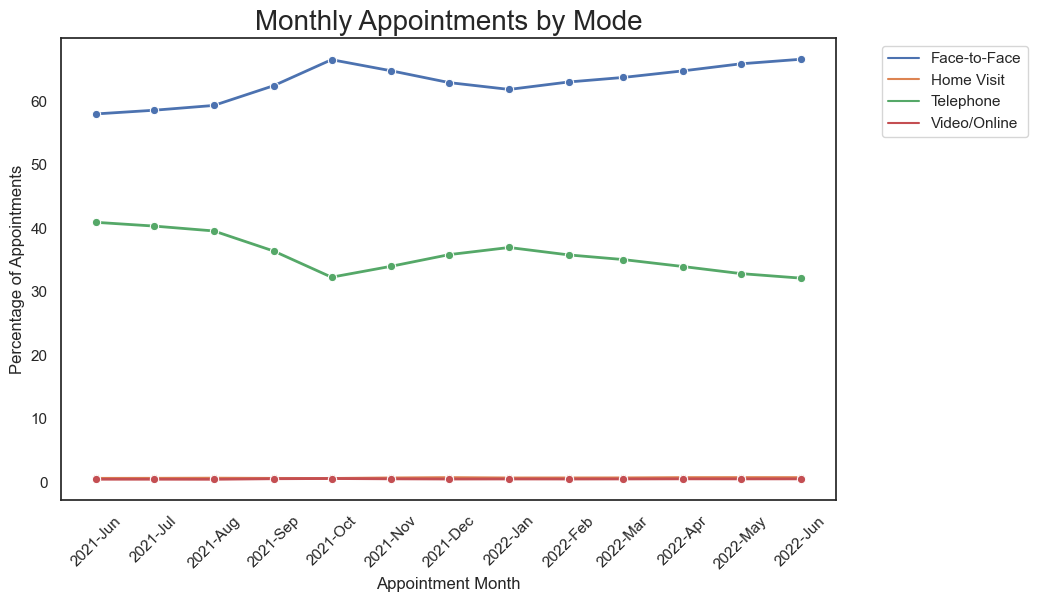

In [200]:
# Create df
ar_app_mode_trend = group2_apply_operation(ar_june_2021_onwards,'appointment_month','appointment_mode','count_of_appointments',sum)

# Filter out Unknown data to aid visualization.
ar_app_mode_trend = ar_app_mode_trend[ar_app_mode_trend['appointment_mode'] != 'Unknown']

total_appointments_by_month = ar_app_mode_trend.groupby('appointment_month')['count_of_appointments'].transform('sum')

# Calculate percentage of appointments for each mode
ar_app_mode_trend['percentage'] = (ar_app_mode_trend['count_of_appointments'] / total_appointments_by_month) * 100

#Set the size
plt.figure(figsize=(10, 6))

# Plot the data using seaborn lineplot
ax = sns.lineplot(x='appointment_month', y='percentage', hue='appointment_mode', data=ar_app_mode_trend, marker='o',linewidth=2)

# Set labels and title for the plot
ax.set_title('Monthly Appointments by Mode', fontsize=20)
ax.set_xlabel('Appointment Month')
ax.set_ylabel('Percentage of Appointments')

# Extract date range for the x-axis tick labels
date_range = pd.date_range(start=ar_app_mode_trend['appointment_month'].min(), end=ar_app_mode_trend['appointment_month'].max(), freq='MS')

# Format x-axis tick labels
ax.set_xticks(date_range)
ax.set_xticklabels(date_range.strftime('%Y-%b'), rotation=45)

ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

# Show the plot
plt.show()

Face to Face appointment are the preferred form of consultation.
We can observe an inverse relationship: At the increase of face to face appointment, telephone decrease and viceversa.

higher demand for in-person consultations, might mean  adequate staffing and capacity to accommodate patient needs. However, April 2022 (typically less busy than March 2021 were we observed higher face to face consultation suggesting possible suppressed demand.
Let's look at waiting times. 


**Trends in time between booking an appointment**

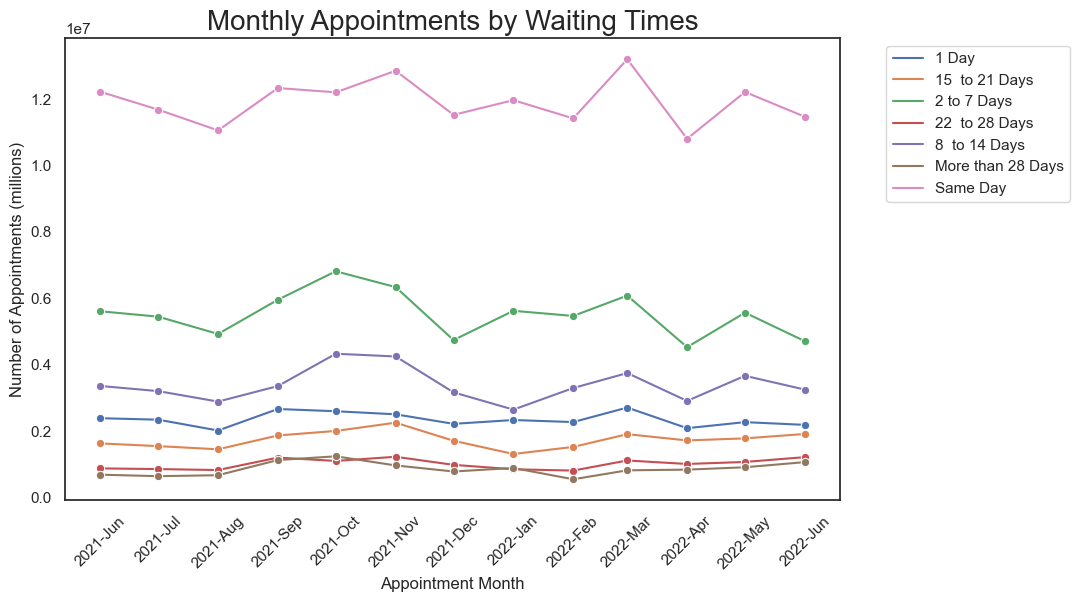

In [201]:
# Create a lineplot to answer the question.
# This function group by sum appointement 
wt_by_month = group2_apply_operation(ar_june_2021_onwards,'appointment_month','time_between_book_and_appointment', 'count_of_appointments',sum)

wt_by_month_trend = wt_by_month[wt_by_month['time_between_book_and_appointment'] != 'Unknown / Data Quality']

# Set size of the plot
plt.figure(figsize=(10, 6))

# Create lineplot 
ax = sns.lineplot(x='appointment_month', y='count_of_appointments', hue='time_between_book_and_appointment', data=wt_by_month_trend, marker='o')

# Set labels and title for the plot
ax.set_title('Monthly Appointments by Waiting Times', fontsize=20)
ax.set_xlabel('Appointment Month')
ax.set_ylabel('Number of Appointments (millions)')

#Set date range for the x-axis
date_range = pd.date_range(start=wt_by_month_trend['appointment_month'].min(), end=wt_by_month_trend['appointment_month'].max(), freq='MS')

# Format x-axis tick labels
ax.set_xticks(date_range)
ax.set_xticklabels(date_range.strftime('%Y-%b'), rotation=45)

# Set legend
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

plt.show()

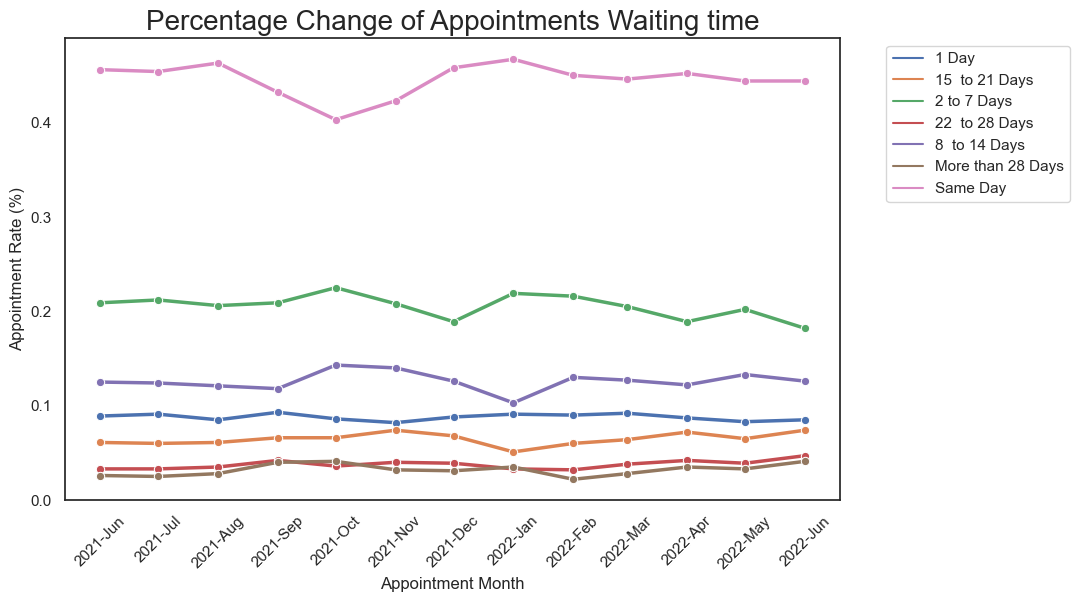

In [202]:
# Look at waiting times appointmemt rate over time 
# Pivot the aggregated DataFrame
wt_by_month_pivot = wt_by_month.pivot(index='appointment_month', columns='time_between_book_and_appointment', values='count_of_appointments')
wt_by_month_pivot.reset_index(inplace=True) 

# Create a copy of the DataFrame
wt_by_month_rate = wt_by_month_pivot.copy()

# Apply lambda function to convert to %
wt_by_month_rate[['1 Day','15  to 21 Days','2 to 7 Days','22  to 28 Days','8  to 14 Days','More than 28 Days','Same Day','Unknown / Data Quality']]\
= wt_by_month_rate[['1 Day','15  to 21 Days','2 to 7 Days','22  to 28 Days','8  to 14 Days','More than 28 Days','Same Day','Unknown / Data Quality']]\
.apply(lambda x: x / x.sum(), axis=1).round(3)

# Melt the DataFrame for visualization
wt_by_month_rate = wt_by_month_rate.melt(id_vars='appointment_month', var_name='time_between_book_and_appointment', value_name='Percentage')

# Filter out 'Unknown / Data Quality'
wt_by_month_rate = wt_by_month_rate[wt_by_month_rate['time_between_book_and_appointment'] != 'Unknown / Data Quality']

# Set size of the plot
plt.figure(figsize=(10, 6))

# Plot 
ax = sns.lineplot(x='appointment_month', y='Percentage', hue='time_between_book_and_appointment', data=wt_by_month_rate,\
                  marker='o',linewidth='2.5')

# Set labels and title for the plot
ax.set_title('Percentage Change of Appointments Waiting time', fontsize=20)
ax.set_xlabel('Appointment Month')
ax.set_ylabel('Appointment Rate (%)')

# Set date range for the x-axis
date_range = pd.date_range(start=wt_by_month_rate['appointment_month'].min(), 
                           end=wt_by_month_rate['appointment_month'].max(), 
                           freq='MS')
# Format x-axis tick labels
ax.set_xticks(date_range)
ax.set_xticklabels(date_range.strftime('%Y-%b'), rotation=45)


# Set legend outside the chart
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

# Show the plot
plt.show()


The above observation are here corroborated. Same day appointments are diminished confirming hypohtesis of bakclogs and delay in service provision. Waiting for more then 2 weeks and over has increased  suggest that capacity in the network is not adequate to cope with the current demand. 

Moreover % of same day and 1 day appointment tend to decrease during busy period (October drastically fall) meaning that gp facilities struggle to accomodate immediate or urgen patients needs This decline could be attributed to various factors such as increased patient volume, limited availability of appointments, or resource constraints.

Overall waiting time have increased. Still corroborating insight in struggle of the system to cope with the demand. 


**Check of GP FTE (Full time Equivalent) over time** 

(array([18962., 18993., 19024., 19052., 19083., 19113., 19144., 19174.]),
 [Text(18962.0, 0, '2021-12'),
  Text(18993.0, 0, '2022-01'),
  Text(19024.0, 0, '2022-02'),
  Text(19052.0, 0, '2022-03'),
  Text(19083.0, 0, '2022-04'),
  Text(19113.0, 0, '2022-05'),
  Text(19144.0, 0, '2022-06'),
  Text(19174.0, 0, '2022-07')])

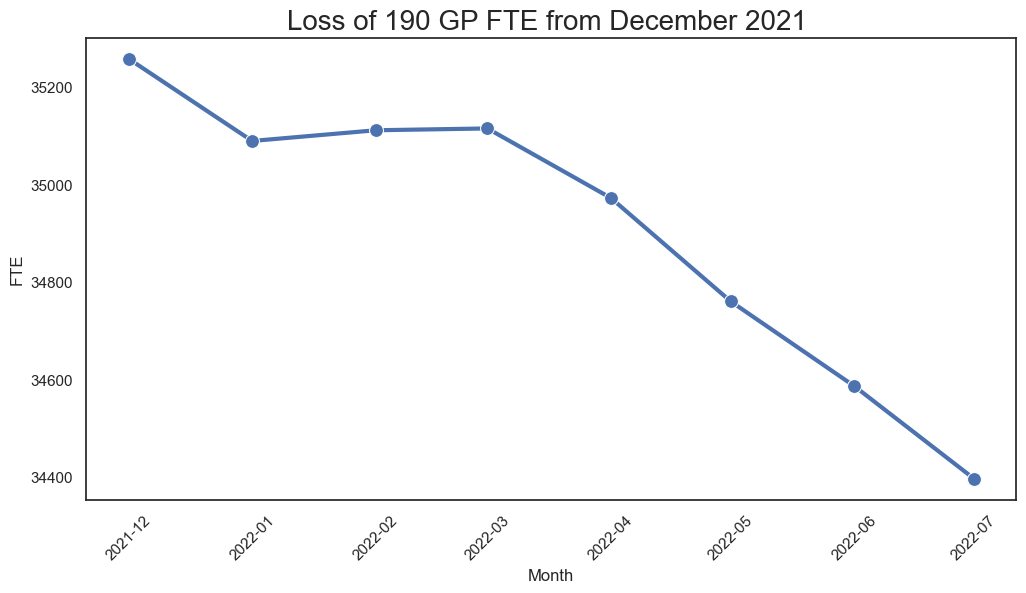

In [234]:
# group by 
fte_by_month= group1_apply_operation(gp,'Month','Total',sum)

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=fte_by_month, x='Month', y='Total', ci=None, marker='o',markersize= 10, linewidth=3)

# Customizing the plot
plt.xlabel('Month')
plt.ylabel('FTE')
plt.title('Loss of 190 GP FTE from December 2021 ', fontsize=20)


# Corrected y-axis tick label rotation
plt.xticks(rotation=45)



NHS has lost the equivalent of 7125 hours worked across the network. 

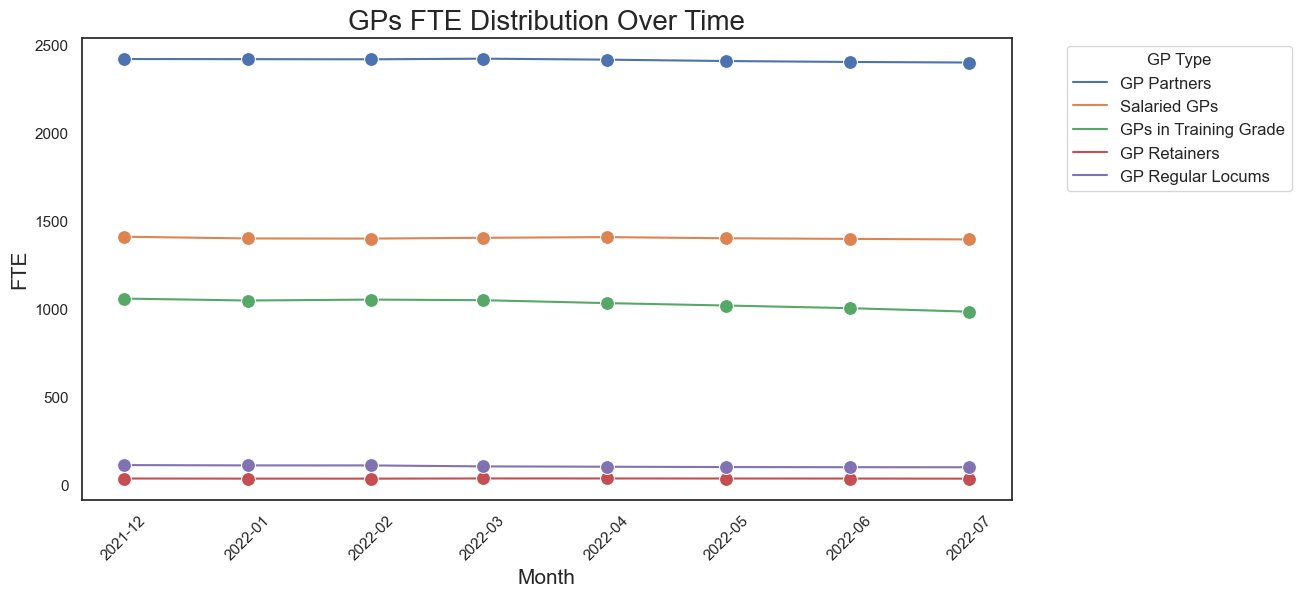

In [277]:
# Melt the Gp DataFrame to prepare visualisation 
melted_gp1 = gp.melt(id_vars=['Month'], 
                    value_vars=['GP Partners', 'Salaried GPs', 'GPs in Training Grade', 'GP Retainers', 'GP Regular Locums '],
                    var_name='gp_type', 
                    value_name='FTE')

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=melted_gp1, x='Month', y='FTE', hue='gp_type', ci=None, marker='o', markersize = 10)

# Customizing the plot
plt.xlabel('Month', size = 15)
plt.ylabel('FTE', size = 15)
plt.title('GPs FTE Distribution Over Time', fontsize=20)

# Corrected y-axis tick label rotation
plt.xticks(rotation=45)

# Set legend outside the chart
plt.legend(title='GP Type', loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=12, title_fontsize=12)

# Show the plot
plt.show()



We would need a longer time frame to draw conclusion, but since decemeber the split by workforce has stayed mostly the same. THis does not reflect the spike in demand, and might suggest that the capacity has been not adequate. Visuals are also skewed by low values; I sugguest splitting the categeories in future.

**Look at changes of FTE by Regions**

Area
East of England             2.07
London                      2.27
Midlands                    2.66
North East and Yorkshire    3.13
North West                  2.20
South East of England       1.60
South West of England       3.09
dtype: float64


<Figure size 1200x800 with 0 Axes>

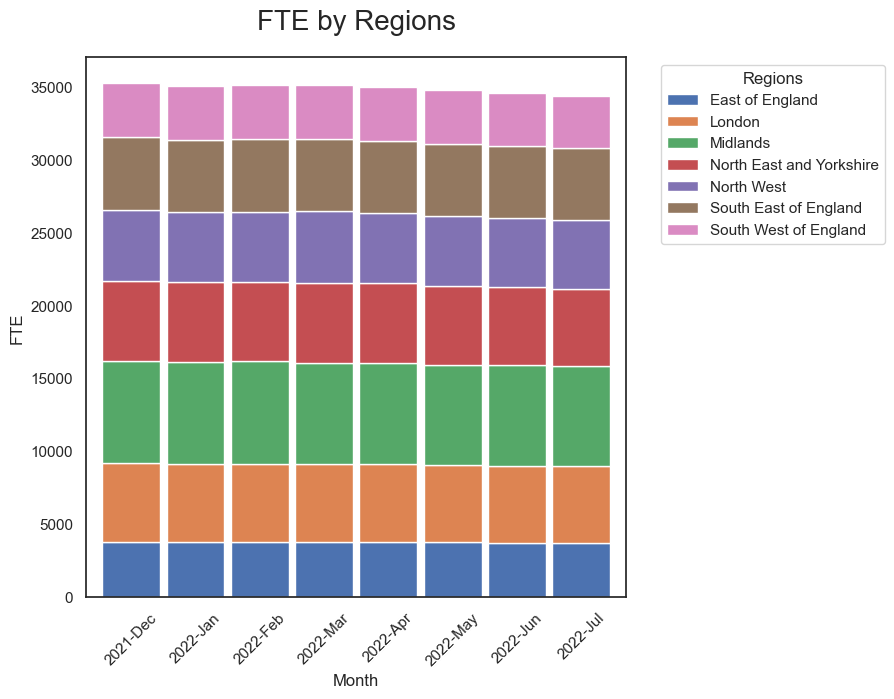

In [261]:
# Set size of the plot
plt.figure(figsize=(12, 8))

# Group the data by month and region and calculate the total FTE
gp_fte_by_month_region = group2_apply_operation(gp, 'Month', 'Area', 'Total', sum)

# Pivot the dataframe to prepare for display in a stacked bar chart
pivot_df = gp_fte_by_month_region.pivot(index='Month', columns='Area', values='Total')


#Quantify the absolute change 
absolute_change = pivot_df.iloc[0] - pivot_df.iloc[-1]

# Quantify the percentage change 
percentage_change = (((pivot_df.iloc[0] - pivot_df.iloc[-1]) / pivot_df.iloc[0]) * 100).round(2)

# Print 
print(percentage_change)

#Plot
ax = pivot_df.plot(kind='bar', stacked=True, width=0.9)

# Add labels and title directly using pandas plotting
ax.set_xlabel('Month')
ax.set_ylabel('FTE')
ax.set_title('FTE by Regions', fontsize=20, pad = 20)

# Format x-axis tick labels
ax.set_xticklabels(pivot_df.index.strftime('%Y-%b'), rotation=45)

# Adjust the legend to be outside the plot
ax.legend(title='Regions', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout 
plt.subplots_adjust(left=0.1, bottom=0.1, right=1, top=1, wspace=0.4, hspace=0.5)

# Show plot
plt.show()


Although slight, North East and Yorkshire and South West of England experienced the greatest reduction in FTE  while the South East of England NHS Network the smallest. 
    

**Trends of DNA by Waiting Times**

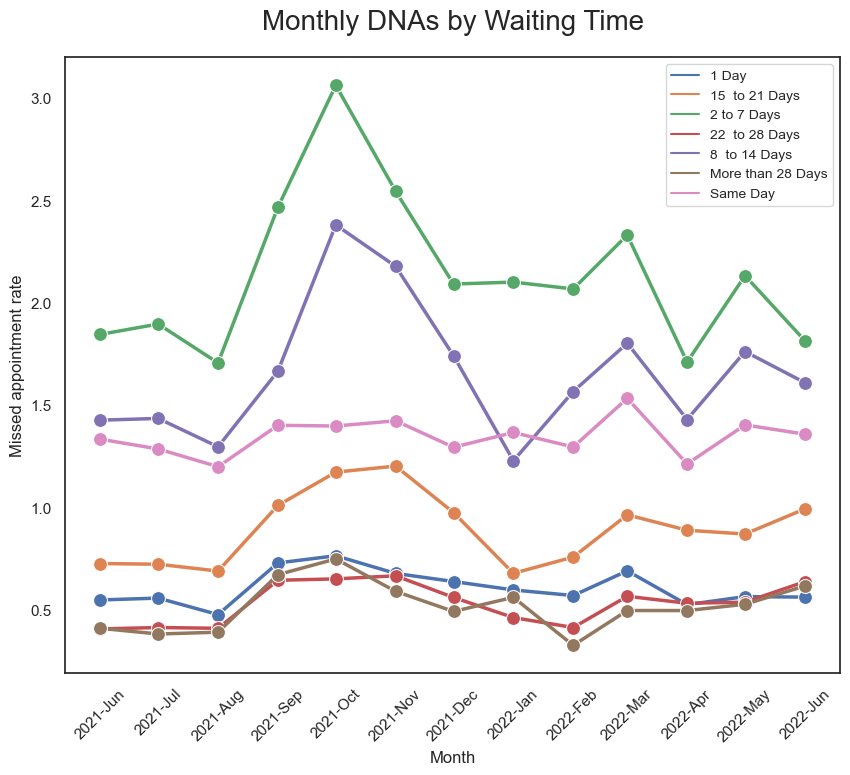

In [239]:
# Create subset with only DNA appointments
dna_data = ar_june_2021_onwards[ar_june_2021_onwards['appointment_status'] == 'DNA']

# Group by appointment month, refer to user function
dna_by_month_and_time = group_2variables_by_cnt_appointments(dna_data,'appointment_month','time_between_book_and_appointment')

# Pivot the df
dna_by_month_and_time_pivot = dna_by_month_and_time.pivot(index='appointment_month', columns ='time_between_book_and_appointment', values='total_appointment')

# View output
dna_by_month_and_time_pivot.reset_index(inplace=True)

# Drop Unknown / Data Quality column
dna_by_month_and_time_pivot.drop('Unknown / Data Quality', axis=1, inplace=True)

# Prepare the df for plotting
dna_by_month_and_time_pivot = dna_by_month_and_time_pivot.melt(id_vars='appointment_month', var_name ='time_between_book_and_appointment', value_name='dna_appointments')

#get %
dna_by_month_and_time_pivot['percent']= (dna_by_month_and_time_pivot['dna_appointments']/ dna_by_month_and_time_pivot['dna_appointments'].sum())*100

# Set size of the plot
plt.figure(figsize=(10, 8))

#Plot 
ax= sns.lineplot(data = dna_by_month_and_time_pivot, x = 'appointment_month', y='percent', hue = 'time_between_book_and_appointment', marker= 'o',
                 linewidth='2.5', markersize = 10)

# Set labels and title for the plot
ax.set_title('Monthly DNAs by Waiting Time', fontsize=20, pad = 20)
ax.set_xlabel('Month')
ax.set_ylabel('Missed appointment rate')


# Set date range for the x-axis
date_range = pd.date_range(start=dna_by_month_and_time_pivot['appointment_month'].min(), 
                           end=dna_by_month_and_time_pivot['appointment_month'].max(), 
                           freq='MS')
# Format x-axis tick labels
ax.set_xticks(date_range)
ax.set_xticklabels(date_range.strftime('%Y-%b'), rotation=45)


# Set legend outside the chart with smaller font size
ax.legend(prop={'size': 10})

# Show the plot
plt.show()


In [264]:
dna_by_month_and_time_pivot['time_between_book_and_appointment'].unique()

array(['1 Day', '15  to 21 Days', '2 to 7 Days', '22  to 28 Days',
       '8  to 14 Days', 'More than 28 Days', 'Same Day'], dtype=object)

Overall dna increase with waiting times. 

October and March, which, as seen above, are the busiest months with peak appointments, correspond with higher DNA (Did Not Attend) rates for appointments with waits of over a week (8 to 14 days, 15 to 21 days, 22 to 28 days, and more than 28 days). This reflects the increased number of appointments due to elevated demand for healthcare services and underscores even more the importance of implementing targeted reminders.

**Display Relation Waiting Times & DNA**

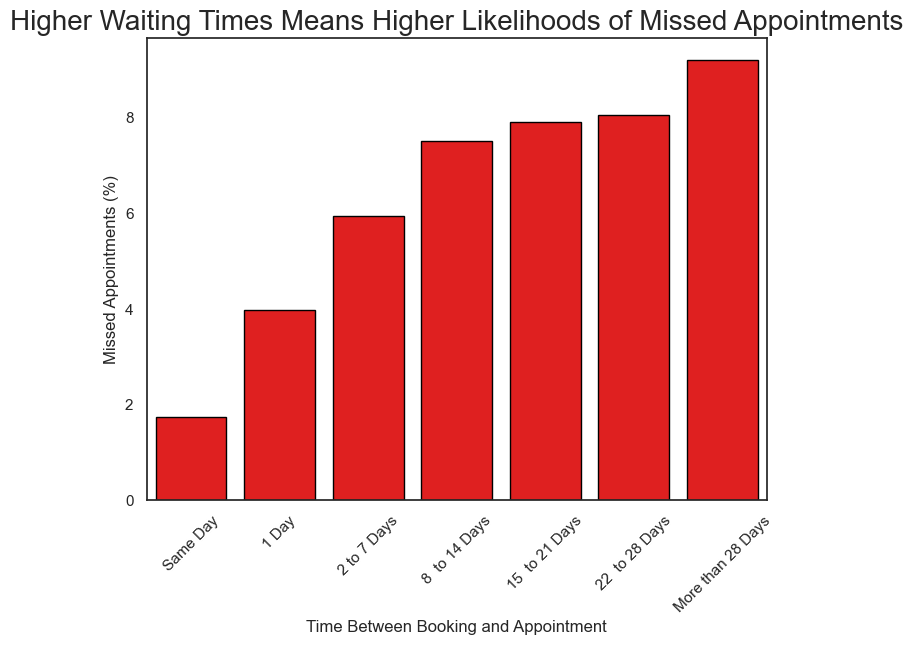

In [207]:
# Group by DNA appointments count by waiting time. 
dna_by_waiting_time = dna_data.groupby('time_between_book_and_appointment')['count_of_appointments'].sum()

# Define tot appointments relative to the period of interest 
total_appointments_by_time = ar_june_2021_onwards.groupby('time_between_book_and_appointment')['count_of_appointments'].sum()


# Determine % of DNA appointments relative to the total appointments for each time interval
dna_percentage_by_time = (dna_by_waiting_time / total_appointments_by_time) * 100

# Convert the Series to a DataFrame, reset the index and rename column
dna_percentage_by_time = dna_percentage_by_time.reset_index(name='%_relative_DNA')

# Filter out Unknown/data quality data
dna_percentage_by_time = dna_percentage_by_time[dna_percentage_by_time['time_between_book_and_appointment'] != 'Unknown / Data Quality']

# Plot the percentage of DNA appointments against the waiting times
plt.figure(figsize=(8, 6))

sns.barplot(x='time_between_book_and_appointment', y='%_relative_DNA', data=dna_percentage_by_time, color='red',
            order=['Same Day', '1 Day', '2 to 7 Days', '8  to 14 Days', '15  to 21 Days', '22  to 28 Days', 'More than 28 Days'], edgecolor = 'black')

# Set Title and lable
plt.title('Higher Waiting Times Means Higher Likelihoods of Missed Appointments', fontsize=20)
plt.xlabel('Time Between Booking and Appointment')
plt.ylabel('Missed Appointments (%)')
plt.xticks(rotation=45)
plt.show()



**Correlation GP type Vs Missed Appointment**

Correlation between 'DNA' and 'Total_FTE': -0.01874316867334107
Correlation between 'DNA' and 'GP Partners': -0.003929331378308698
Correlation between 'DNA' and 'GP Retainers': 0.5371353305144903
Correlation between 'DNA' and 'GPs in Training Grade': -0.016693453972388212
Correlation between 'DNA' and 'Salaried GPs': -0.20065445812305358
Correlation between 'DNA' and :'GP Regular Locums': -0.20065445812305358


Text(0.5, 1.0, 'Correlation between DNA  and GP Retainers')

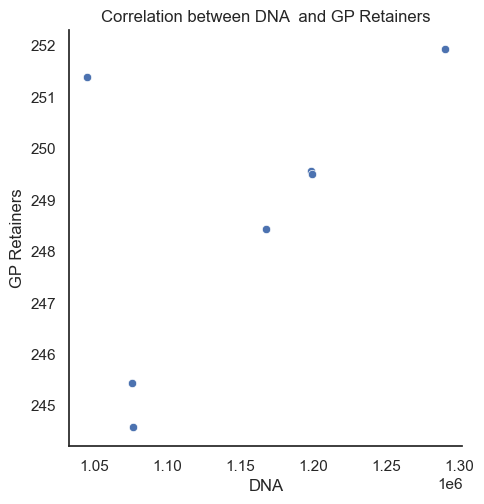

In [208]:
# Transform AR dataframe
ar_grouped = group2_apply_operation(ar, 'appointment_month', 'appointment_status', 'count_of_appointments', sum)

# Ensure 'appointment_month' is in datetime format
ar_grouped['appointment_month'] = pd.to_datetime(ar_grouped['appointment_month'])

# Filter ar_grouped to match the period time of gp (from '2021-11-01' onwards)
ar_grouped_filtered = ar_grouped[ar_grouped['appointment_month'] >= '2021-11-01']

# Pivot the filtered ar_grouped dataframe
ar_grouped_pivot = ar_grouped_filtered.pivot(index='appointment_month', columns='appointment_status', values='count_of_appointments').reset_index()

# Prepare GP dataframe
melted_gp = gp.melt(id_vars=['Month'], var_name='GP_Type', value_vars=['GP Partners', 'Salaried GPs', 'GPs in Training Grade', 'GP Retainers', 'GP Regular Locums '], value_name='FTE')

# Ensure 'Month' is in datetime format
melted_gp['Month'] = pd.to_datetime(melted_gp['Month'])

# Group by Month and GP_Type and sum FTE
gp_grouped = melted_gp.groupby(['Month', 'GP_Type'])['FTE'].sum().reset_index()

gp_pivot = gp_grouped.pivot(index='Month', columns='GP_Type', values='FTE').reset_index()

gp_pivot['Total_FTE'] = gp_pivot['GP Partners'] + \
                    gp_pivot['Salaried GPs'] + \
                    gp_pivot['GPs in Training Grade'] + \
                    gp_pivot['GP Retainers'] + \
                    gp_pivot['GP Regular Locums ']

# Rename 'appointment_month' to 'Month' in ar_grouped_pivot to merge
ar_grouped_pivot.rename(columns={'appointment_month': 'Month'}, inplace= True)

# Merge gp and ar 
gp_app_merge = pd.merge(ar_grouped_pivot, gp_pivot, on='Month')
gp_app_merge



#Check correlation 
correlation_total_fte = gp_app_merge['DNA'].corr(gp_app_merge['Total_FTE'])

# Calculate correlation between 'DNA' and each GP type individually
correlation_gp_partners = gp_app_merge['DNA'].corr(gp_app_merge['GP Partners'])
correlation_gp_retainers = gp_app_merge['DNA'].corr(gp_app_merge['GP Retainers'])
correlation_gps_in_training = gp_app_merge['DNA'].corr(gp_app_merge['GPs in Training Grade'])
correlation_salaried_gps = gp_app_merge['DNA'].corr(gp_app_merge['Salaried GPs'])
correlation_salaried_gps = gp_app_merge['DNA'].corr(gp_app_merge['GP Regular Locums '])


# Print the correlations
print("Correlation between 'DNA' and 'Total_FTE':",correlation_total_fte)
print("Correlation between 'DNA' and 'GP Partners':", correlation_gp_partners)
print("Correlation between 'DNA' and 'GP Retainers':", correlation_gp_retainers)
print("Correlation between 'DNA' and 'GPs in Training Grade':", correlation_gps_in_training)
print("Correlation between 'DNA' and 'Salaried GPs':", correlation_salaried_gps)
print("Correlation between 'DNA' and :'GP Regular Locums':",correlation_salaried_gps)


# Create a scatter plot
sns.relplot(x='DNA', y='GP Retainers', data=gp_app_merge)
plt.title('Correlation between DNA  and GP Retainers')



**N.B** This correlation could suggest that patients are more likely to miss appointments when they perceive the availability of doctors to be limited or when they feel that the appointment might not be as beneficial because the doctor is not available full-time.

However, correlation alone cannot establish causation, so it's essential to consider other potential factors that may contribute to missed appointments, such as scheduling issues, communication barriers, or individual patient circumstances.

Moreover, these results need to be interpreted with caution due to the limited number of entries. As such, they will not be reported to stakeholders

**Is there any correlation at the geographic level ?**

Correlation between 'DNA' and 'Total_FTE': 0.07007608127783606
Correlation between 'DNA' and 'GP Partners': -0.017881444462289703
Correlation between 'DNA' and 'GP Retainers': -0.3252180357852262
Correlation between 'DNA' and 'GPs in Training Grade': 0.05162403509388961
Correlation between 'DNA' and 'Salaried GPs': 0.22568020129687885
Correlation between 'DNA' and :'GP Regular Locums': 0.22568020129687885


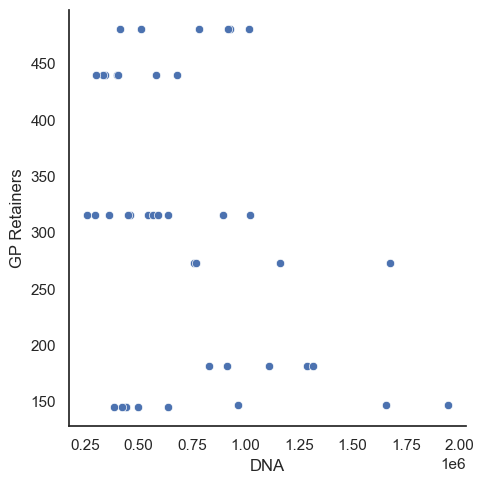

In [266]:
# Transform AR dataframe
ar_group_icb_status = group2_apply_operation(ar, 'icb_ons_code', 'appointment_status', 'count_of_appointments', sum)

# Pivot the filtered ar_grouped dataframe
ar_group_icb_status_pivot = ar_group_icb_status.pivot(index='icb_ons_code', columns='appointment_status', values='count_of_appointments').reset_index()

# Prepare GP dataframe
melted_gp_icb_idx = gp_merge_geo_data.melt(id_vars=['icb_ons_code'], var_name='GP_Type', value_vars=['GP Partners', 'Salaried GPs', 'GPs in Training Grade', 'GP Retainers', 'GP Regular Locums '], value_name='FTE')

# Group by icb_ons_code and GP_Type and sum FTE
gp_group_icb = melted_gp_icb_idx.groupby(['icb_ons_code', 'GP_Type'])['FTE'].sum().reset_index()

gp_icb_pivot = gp_group_icb.pivot(index='icb_ons_code', columns='GP_Type', values='FTE').reset_index()

gp_icb_pivot['Total_FTE']  = gp_icb_pivot['GP Partners'] + \
                    gp_icb_pivot['Salaried GPs'] + \
                    gp_icb_pivot['GPs in Training Grade'] + \
                    gp_icb_pivot['GP Retainers'] + \
                    gp_icb_pivot['GP Regular Locums ']


# Merge gp and ar 
gp_app_icb_merge = pd.merge(ar_group_icb_status_pivot,gp_icb_pivot , on='icb_ons_code')
gp_app_icb_merge

#Check correlation 
correlation_total_fte2 = gp_app_icb_merge['DNA'].corr(gp_app_icb_merge['Total_FTE'])

# Calculate correlation between 'DNA' and each GP type individually in gp_app_icb_merge
correlation_gp_partners2 = gp_app_icb_merge['DNA'].corr(gp_app_icb_merge['GP Partners'])
correlation_gp_retainers2 = gp_app_icb_merge['DNA'].corr(gp_app_icb_merge['GP Retainers'])
correlation_gps_in_training2 = gp_app_icb_merge['DNA'].corr(gp_app_icb_merge['GPs in Training Grade'])
correlation_salaried_gps2 = gp_app_icb_merge['DNA'].corr(gp_app_icb_merge['Salaried GPs'])
correlation_gp_regular_locums2 = gp_app_icb_merge['DNA'].corr(gp_app_icb_merge['GP Regular Locums '])

# Print the correlations
print("Correlation between 'DNA' and 'Total_FTE':",correlation_total_fte2)
print("Correlation between 'DNA' and 'GP Partners':", correlation_gp_partners2)
print("Correlation between 'DNA' and 'GP Retainers':", correlation_gp_retainers2)
print("Correlation between 'DNA' and 'GPs in Training Grade':", correlation_gps_in_training2)
print("Correlation between 'DNA' and 'Salaried GPs':", correlation_salaried_gps2)
print("Correlation between 'DNA' and :'GP Regular Locums':",correlation_salaried_gps2)


# Create a scatter plot
sns.relplot(x='DNA', y='GP Retainers', data=gp_app_icb_merge, kind='scatter')


No correlation at the geographic level. 

**Spred of Appointments by  Service settings**

In [280]:
nc

appointment_date icb_ons_code  \
0            2021-08-02    E54000050   
1            2021-08-02    E54000050   
2            2021-08-02    E54000050   
3            2021-08-02    E54000050   
4            2021-08-02    E54000050   
...                 ...          ...   
817389       2022-06-30    E54000054   
817390       2022-06-30    E54000054   
817391       2022-06-30    E54000054   
817392       2022-06-30    E54000054   
817393       2022-06-30    E54000054   

                             sub_icb_location_name            service_setting  \
0       NHS North East and North Cumbria ICB - 00L       Primary Care Network   
1       NHS North East and North Cumbria ICB - 00L                      Other   
2       NHS North East and North Cumbria ICB - 00L           General Practice   
3       NHS North East and North Cumbria ICB - 00L           General Practice   
4       NHS North East and North Cumbria ICB - 00L           General Practice   
...                                            ...                        ...   
817389              NHS West Yorkshire ICB - X2C4Y  Extended Access Provision   
817390              NHS West Yorkshire ICB - X2C4Y  Extended Access Provision   
817391              NHS West Yorkshire ICB - X2C4Y  Extended Access Provision   
817392              NHS West Yorkshire ICB - X2C4Y  Extended Access Provision   
817393              NHS West Yorkshire ICB - X2C4Y  Extended Access Provision   

                  context_type                       national_category  \
0       Care Related Encounter  Patient contact during Care Home Round   
1       Care Related Encounter                         Planned Clinics   
2       Care Related Encounter                              Home Visit   
3       Care Related Encounter              General Consultation Acute   
4       Care Related Encounter            Structured Medication Review   
...                        ...                                     ...   
817389  Care Related Encounter             Unplanned Clinical Activity   
817390  Care Related Encounter                         Planned Clinics   
817391  Care Related Encounter              Planned Clinical Procedure   
817392  Care Related Encounter            General Consultation Routine   
817393  Care Related Encounter              General Consultation Acute   

        count_of_appointments appointment_month  
0                           3        2021-08-01  
1                           7        2021-08-01  
2                          79        2021-08-01  
3                         725        2021-08-01  
4                           2        2021-08-01  
...                       ...               ...  
817389                     12        2022-06-01  
817390                      4        2022-06-01  
817391                     92        2022-06-01  
817392                      4        2022-06-01  
817393                     19        2022-06-01  

[817394 rows x 8 columns]

In [294]:
nc

appointment_date icb_ons_code  \
0            2021-08-02    E54000050   
1            2021-08-02    E54000050   
2            2021-08-02    E54000050   
3            2021-08-02    E54000050   
4            2021-08-02    E54000050   
...                 ...          ...   
817389       2022-06-30    E54000054   
817390       2022-06-30    E54000054   
817391       2022-06-30    E54000054   
817392       2022-06-30    E54000054   
817393       2022-06-30    E54000054   

                             sub_icb_location_name            service_setting  \
0       NHS North East and North Cumbria ICB - 00L       Primary Care Network   
1       NHS North East and North Cumbria ICB - 00L                      Other   
2       NHS North East and North Cumbria ICB - 00L           General Practice   
3       NHS North East and North Cumbria ICB - 00L           General Practice   
4       NHS North East and North Cumbria ICB - 00L           General Practice   
...                                            ...                        ...   
817389              NHS West Yorkshire ICB - X2C4Y  Extended Access Provision   
817390              NHS West Yorkshire ICB - X2C4Y  Extended Access Provision   
817391              NHS West Yorkshire ICB - X2C4Y  Extended Access Provision   
817392              NHS West Yorkshire ICB - X2C4Y  Extended Access Provision   
817393              NHS West Yorkshire ICB - X2C4Y  Extended Access Provision   

                  context_type                       national_category  \
0       Care Related Encounter  Patient contact during Care Home Round   
1       Care Related Encounter                         Planned Clinics   
2       Care Related Encounter                              Home Visit   
3       Care Related Encounter              General Consultation Acute   
4       Care Related Encounter            Structured Medication Review   
...                        ...                                     ...   
817389  Care Related Encounter             Unplanned Clinical Activity   
817390  Care Related Encounter                         Planned Clinics   
817391  Care Related Encounter              Planned Clinical Procedure   
817392  Care Related Encounter            General Consultation Routine   
817393  Care Related Encounter              General Consultation Acute   

        count_of_appointments appointment_month  
0                           3        2021-08-01  
1                           7        2021-08-01  
2                          79        2021-08-01  
3                         725        2021-08-01  
4                           2        2021-08-01  
...                       ...               ...  
817389                     12        2022-06-01  
817390                      4        2022-06-01  
817391                     92        2022-06-01  
817392                      4        2022-06-01  
817393                     19        2022-06-01  

[817394 rows x 8 columns]

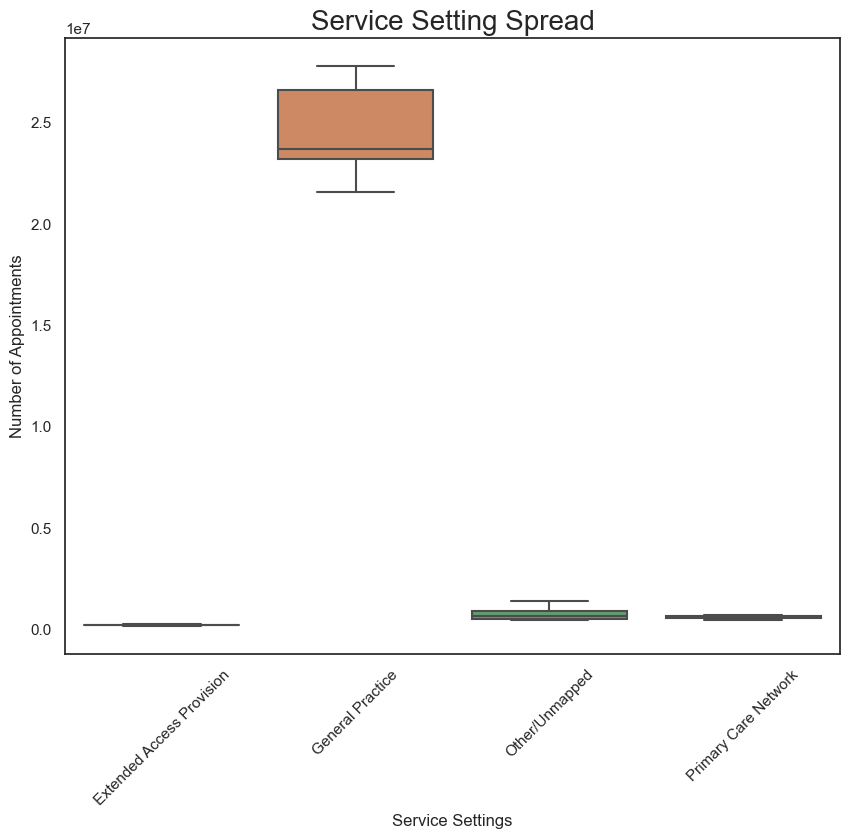

In [292]:
# Create a boxplot to investigate the spread of service settings. Refer to nc_ss used above
plt.figure(figsize=(10, 8))
ax = sns.boxplot(x='service_setting', y='count_of_appointments', data=nc_ss)

# Set Title and lable
plt.title('Service Setting Spread', fontsize=20)
plt.xlabel('Service Settings')
plt.ylabel('Number of Appointments')
plt.xticks(rotation=45)

# View boxplot
plt.show()

This suggests us two things: 
- GP Practices are the settings that covers the most appointemnts and hence the one where resource utilisation is higher. 
- Distribution of total appointment by month is positively rigth skewed.This suggest that the median is below the average value and for our analysis, that there have been months (from 08/21 to 06/22) where appintments were lower compared to overall pattern. 
As the data from previous analysis corroborated, this is most likely due to seasonal variations. 

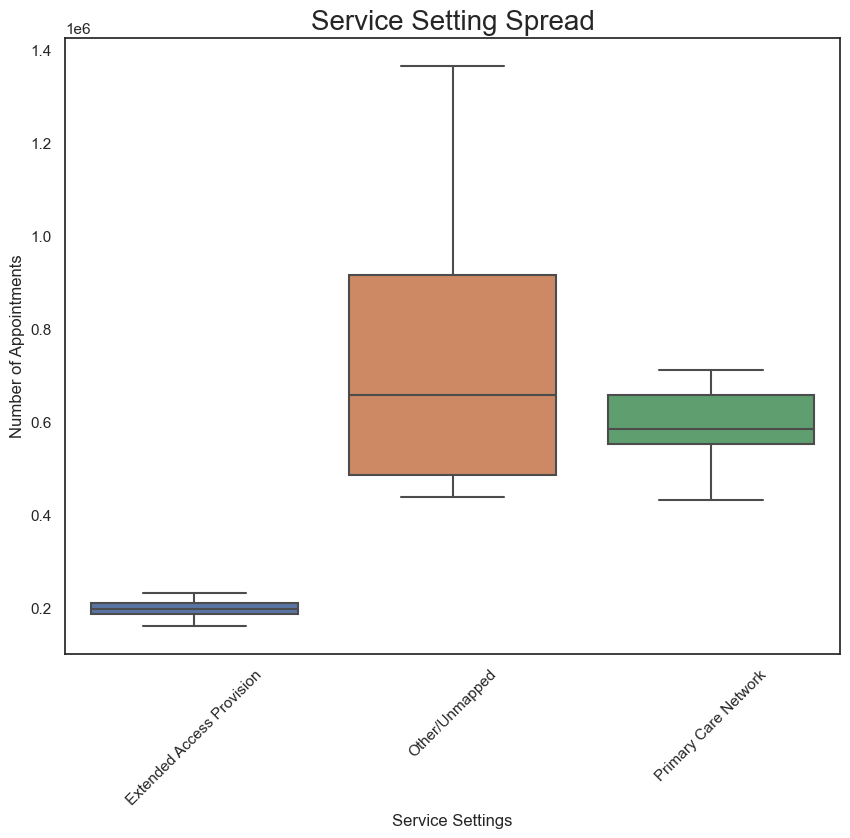

In [211]:
# Create a boxplot to investigate the service settings without GP to aid comparison
nc_ss_without_gp = nc_ss[nc_ss['service_setting']!= 'General Practice']	

plt.figure(figsize=(10, 8))
ax = sns.boxplot(x='service_setting', y='count_of_appointments', data=nc_ss_without_gp)

# Set Title and lable
plt.title('Service Setting Spread', fontsize=20)
plt.xlabel('Service Settings')
plt.ylabel('Number of Appointments')
plt.xticks(rotation=45)

# View boxplot
plt.show()


This is less marked in other settings. 

### ANALYSIS OF SENTIMENTS

#### Analysis of Twitter with hashtags related to healthcare in the UK.

In [212]:
pip install textblob

Note: you may need to restart the kernel to use updated packages.


In [213]:
pip install textblob

Note: you may need to restart the kernel to use updated packages.


In [214]:
# Libraries and settings needed for analysis.
import re
from textblob import TextBlob #pip install textblob
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords 
from wordcloud import WordCloud #pip install wordcloud

nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))


# Set the figure size.
sns.set(rc={'figure.figsize':(8, 6)})

# Set the plot style as white.
sns.set_style('white')

# Maximum column width to display.
pd.options.display.max_colwidth = 200

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rossi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rossi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [215]:
# Load the data set.
tweets = pd.read_csv('tweets.csv')

# View the DataFrame.
tweets.head()

tweet_id  \
0  1567629223795527681   
1  1567582846612553728   
2  1567582787070304256   
3  1567582767625428992   
4  1567582720460570625   

                                                                                                                                                                                           tweet_full_text  \
0  As Arkansas’ first Comprehensive Stroke Certified Center, UAMS provides Arkansans with access to the most advanced stoke care. Join us in our mission to make a difference in the health and well-be...   
1                                                              RT @AndreaGrammer: Work-life balance is at the foundation of how decisions are made and where #PremiseHealth is headed.  We're #hiring for…   
2                                                           RT @OntarioGreens: $10 billion can go a long way to fixing our broken #Healthcare system.\n\nYet Doug Ford would rather spend it ALL on a hig…   
3                                                             RT @modrnhealthcr: 🚨#NEW:🚨 Insurance companies are figuring out the best ways to collect information about members’ race and ethnicity data…   
4  ICYMI: Our recent blogs on Cybersecurity in Accounting https://t.co/4nnK0FiVVL and Digital Transformation in Healthcare Finance https://t.co/jIqn52lHD3 are a great read, take a look!\n\n#blogs #di...   

                                                                                                                                                                                            tweet_entities  \
0  {'hashtags': [{'text': 'Healthcare', 'indices': [253, 264]}], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/yw0cstfmSI', 'expanded_url': 'https://bit.ly/3BiSKbs', 'display_url...   
1  {'hashtags': [{'text': 'PremiseHealth', 'indices': [94, 108]}, {'text': 'hiring', 'indices': [127, 134]}], 'symbols': [], 'user_mentions': [{'screen_name': 'AndreaGrammer', 'name': 'Andrea Grammer...   
2  {'hashtags': [{'text': 'Healthcare', 'indices': [70, 81]}], 'symbols': [], 'user_mentions': [{'screen_name': 'OntarioGreens', 'name': 'Green Party of Ontario', 'id': 37115912, 'id_str': '37115912'...   
3  {'hashtags': [{'text': 'NEW', 'indices': [20, 24]}], 'symbols': [], 'user_mentions': [{'screen_name': 'modrnhealthcr', 'name': 'Modern Healthcare', 'id': 18935711, 'id_str': '18935711', 'indices':...   
4  {'hashtags': [{'text': 'blogs', 'indices': [184, 190]}, {'text': 'digitaltransformation', 'indices': [191, 213]}, {'text': 'cybersecurity', 'indices': [214, 228]}, {'text': 'accounting', 'indices'...   

                                                              tweet_entities_hashtags  \
0                                                                         #Healthcare   
1                                                             #PremiseHealth, #hiring   
2                                                                         #Healthcare   
3                                                                                #NEW   
4  #blogs, #digitaltransformation, #cybersecurity, #accounting, #finance, #healthcare   

                                         tweet_metadata  tweet_retweet_count  \
0  {'iso_language_code': 'en', 'result_type': 'recent'}                    0   
1  {'iso_language_code': 'en', 'result_type': 'recent'}                    2   
2  {'iso_language_code': 'en', 'result_type': 'recent'}                   39   
3  {'iso_language_code': 'en', 'result_type': 'recent'}                    5   
4  {'iso_language_code': 'en', 'result_type': 'recent'}                    0   

   tweet_favorite_count  tweet_favorited  tweet_retweeted tweet_lang  
0                     0            False            False         en  
1                     0            False            False         en  
2                     0            False            False         en  
3                     0            False            False         en  
4           

In [216]:
validate_data(tweets)

Unique values per column:
tweet_id                   1174
tweet_full_text             961
tweet_entities              945
tweet_entities_hashtags     710
tweet_metadata                1
tweet_retweet_count          47
tweet_favorite_count         20
tweet_favorited               1
tweet_retweeted               1
tweet_lang                    1
dtype: int64

Number of duplicate rows:
0

Summary statistics:
           tweet_id  tweet_retweet_count  tweet_favorite_count
count  1.174000e+03          1174.000000            1174.00000
mean   1.567612e+18             8.629472               0.37138
std    2.427553e+13            29.784675               2.04470
min    1.567574e+18             0.000000               0.00000
25%    1.567590e+18             0.000000               0.00000
50%    1.567611e+18             1.000000               0.00000
75%    1.567633e+18             3.000000               0.00000
max    1.567655e+18           303.000000              42.00000


(tweet_id                   1174
 tweet_full_text             961
 tweet_entities              945
 tweet_entities_hashtags     710
 tweet_metadata                1
 tweet_retweet_count          47
 tweet_favorite_count         20
 tweet_favorited               1
 tweet_retweeted               1
 tweet_lang                    1
 dtype: int64,
 0,
            tweet_id  tweet_retweet_count  tweet_favorite_count
 count  1.174000e+03          1174.000000            1174.00000
 mean   1.567612e+18             8.629472               0.37138
 std    2.427553e+13            29.784675               2.04470
 min    1.567574e+18             0.000000               0.00000
 25%    1.567590e+18             0.000000               0.00000
 50%    1.567611e+18             1.000000               0.00000
 75%    1.567633e+18             3.000000               0.00000
 max    1.567655e+18           303.000000              42.00000)

The tweets dataset does not present any null or duplicate values.

The Average value of tweet_retweet_count and tweet_favorite_count are particularly low, therefore the 25th, 50th (median), and 75th percentiles are also 0 or close to 0. This suggests that a large proportion of the values in the 'tweet_favorite_count' column are 0.

We will look into them more closely. Analysing these metrics will provide insight into the popularity of the tweets and the level of engagement. This will be the first step for the hashtag analysis and to identify trends or patterns in the types of tweets

In [217]:
# Look at the distribution of retweets 
retweet_count = tweets['tweet_retweet_count'].value_counts().reset_index()
# View output 
print(retweet_count.sort_values(by= 'tweet_retweet_count',ascending = True))

# Look at the distribution of retweets 
retweet_count = tweets['tweet_favorite_count'].value_counts().reset_index()
# View output 
print(retweet_count.sort_values(by= 'tweet_favorite_count',ascending = True))

    tweet_retweet_count  count
0                     0    526
1                     1    215
2                     2    114
3                     3     70
5                     4     27
4                     5     35
11                    6     12
6                     7     18
8                     8     15
10                    9     13
16                   10      5
15                   11      6
7                    12     16
32                   13      1
37                   14      1
35                   15      1
31                   16      2
41                   19      1
39                   20      1
28                   23      2
29                   24      2
13                   35     10
14                   37      6
40                   39      1
44                   40      1
23                   41      3
18                   44      4
34                   48      1
33                   49      1
17                   53      5
45                   54      1
43      

In [218]:
# Create a new DataFrame containing only the text.
tweets_text = tweets.drop(['tweet_id', 'tweet_entities',
       'tweet_metadata', 'tweet_retweet_count',
       'tweet_favorite_count', 'tweet_favorited', 'tweet_retweeted','tweet_lang'], axis=1)

# View the DataFrame.
tweets_text

# Loop through the messages and create a list of values containing the # symbol.
tags = []

for y in [x.split(' ') for x in tweets['tweet_full_text'].values]:
    for z in y:
        if '#' in z:
            # Change to lowercase.
            tags.append(z.lower())
            
# Display the first 30 records.
tags[:30]

# Create series from list of tags 
tags_series = pd.Series(tags, name="Hashtags")

# Create dataframe with hashtags and count column 
hashtags_df = tags_series.value_counts().reset_index(name= 'Hashtags Count')

# View Output
print(hashtags_df)
print(hashtags_df.info())

           Hashtags  Hashtags Count
0       #healthcare             716
1           #health              80
2         #medicine              41
3               #ai              40
4              #job              38
...             ...             ...
1749      #evestudy               1
1750  #patientdata…               1
1751        #secure               1
1752           #sms               1
1753       \n#csjmu               1

[1754 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754 entries, 0 to 1753
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Hashtags        1754 non-null   object
 1   Hashtags Count  1754 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 27.5+ KB
None


                       Hashtags  Hashtags Count
0                   #healthcare             716
1                       #health              80
2                     #medicine              41
3                           #ai              40
4                          #job              38
..                          ...             ...
58                #saskatchewan              10
59                      #nodejs              10
60       @ingliguori\n\n#python              10
61                        #data              10
62  #healthcare!\n\ninfographic              10

[63 rows x 2 columns]


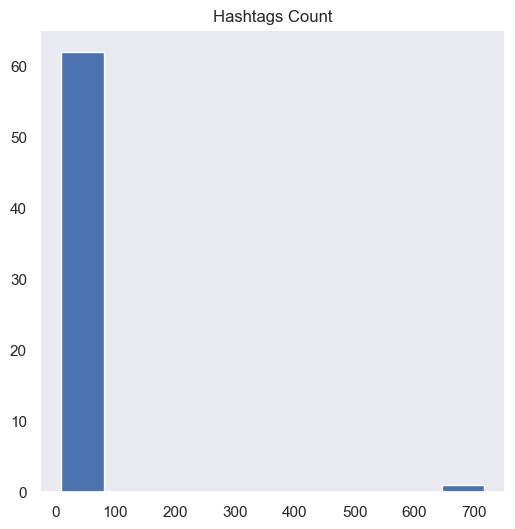

In [219]:
# Display records where the count is larger than 10. 
ht_cnt_greater_than_10 = hashtags_df[hashtags_df['Hashtags Count'] >= 10]

# Display the filtered DataFrame
print(ht_cnt_greater_than_10)

# Look at Hashtags count distribution 
sns.set(rc={'figure.figsize':(6, 6)})
ht_cnt_greater_than_10.hist()
plt.grid(False)


histogram visually display a right-skewed distribution with a long tail, with almost the total (62) of # over 10 recurrencies being less than 100 whilst only 1 has over 700. We will remove outliers to ensure that the visualization accurately reflects the distribution of hashtag frequencies.

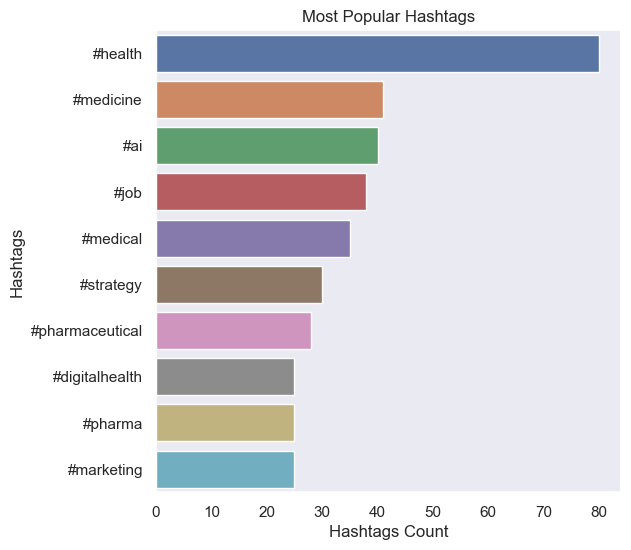

In [301]:
# Exclude outliers
most_frequent_hashtags = ht_cnt_greater_than_10[ht_cnt_greater_than_10['Hashtags Count'] < 100]

# View top 10
most_frequent_hashtags.head(10)

# Set size
sns.set(rc={'figure.figsize':(6, 6)})

# Create a barplot
sns.barplot(y='Hashtags',x='Hashtags Count', data=most_frequent_hashtags.head(10))
plt.title('Most Popular Hashtags')
plt.grid(False)



This graph reveal the top kind of things that people are more tweeting about.

Next we are going to look more closely to the topic. The objective is to understand what the general public think about NHS and most of these hashtags got our attention. 

## Sentiment Analysis

In [221]:

from nltk.corpus import stopwords

# Download NLTK stopwords dataset
nltk.download('stopwords')
nltk.download('punkt')

# Define the list of stopwords
stop_words = set(stopwords.words('english'))


# Process the text column to clean the text.
def clean_text(text):
    '''User defined function to clean tweet text by removing links, RT, and special characters'''
    # Convert to lower case
    text = text.lower()
    # Remove links
    text = re.sub(r"https\S+|www\S+https\S+", '', text, flags=re.MULTILINE)
    # Remove hashtags, retweets and mentions
    text = re.sub(r'@\w+|\#|rt', '', text) 
    # Remove special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Split the text in tokens
    text_tokens = word_tokenize(text)
    # Remove stop words 
    filtered_text = [w for w in text_tokens if not w in stop_words]
    # Then return join filtered text
    return " ".join(filtered_text)

# Call the function and create a new column with the cleaned tweet text 
tweets_text['tweet_clean_text'] = tweets_text['tweet_full_text'].apply(clean_text)

# Drop unclean text column
tweets_text_update = tweets_text.drop(['tweet_full_text'],axis=1)
tweets_text_update

# Check random clean text 
print(tweets_text_update['tweet_clean_text'].iloc[2],"\n")
print(tweets_text_update['tweet_clean_text'].iloc[15],"\n")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rossi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rossi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


10 billion go long way fixing broken healthcare system yet doug ford would rather spend hig 

second health social care complicated practically collapsing sectors need expe handle cant healthsecretary healthcare background 



In [222]:
# Define a function for assessing the sentiment score of the tweet text

def polarity(text):
    ''' This function uses Textblob sentiment method to calculate the polarity'''
    return TextBlob(text).sentiment.polarity
    
# Call the function and create a column with polarity data. 
tweets_text_update['polarity']= tweets_text_update['tweet_clean_text'].apply(polarity)

# Define a function for sentiment label 
def get_tweet_sentiment(tweet):
    '''User defined function to classify sentiment label of tweet
    using TextBlob's sentiment method'''
    # Call the data_processing function to clean the tweet text
    analysis = TextBlob(clean_text(tweet)) 
    # Define sentiment 
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'

tweets_text_update['sentiment']= tweets_text_update['tweet_clean_text'].apply(get_tweet_sentiment)

tweets_text_update.head()



tweet_entities_hashtags  \
0                                                                         #Healthcare   
1                                                             #PremiseHealth, #hiring   
2                                                                         #Healthcare   
3                                                                                #NEW   
4  #blogs, #digitaltransformation, #cybersecurity, #accounting, #finance, #healthcare   

                                                                                                                                                                     tweet_clean_text  \
0    arkansas first comprehensive stroke ceified center uams provides arkansans access advanced stoke care join us mission make difference health wellbeing community next healthcare   
1                                                                                                              worklife balance foundation decisions made premisehealth headed hiring   
2                                                                                         10 billion go long way fixing broken healthcare system yet doug ford would rather spend hig   
3                                                                                          new insurance companies figuring best ways collect information members race ethnicity data   
4  icymi recent blogs cybersecurity accounting digital transformation healthcare finance great read take look blogs digitaltransformation cybersecurity accounting finance healthcare   

   polarity sentiment  
0  0.137500  Positive  
1  0.000000   Neutral  
2 -0.225000  Negative  
3  0.568182  Positive  
4  0.266667  Positive

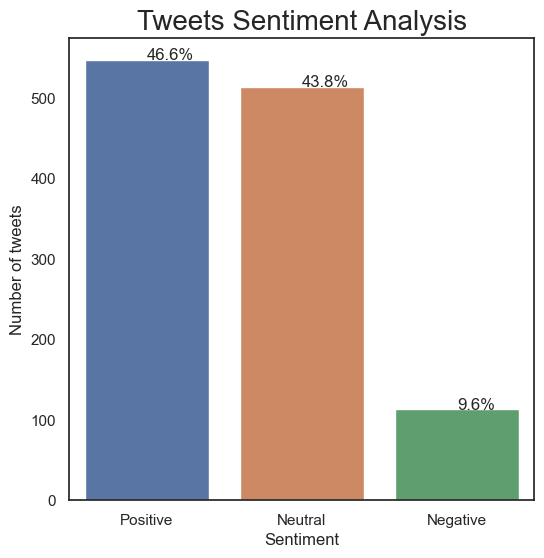

In [223]:
# Set the figure size.
sns.set(rc={'figure.figsize':(6, 6)})
sns.set_style('white')

# Create Countplot to display tweet  
ax = sns.countplot(x='sentiment', data=tweets_text_update)

# Set Title and labels title
ax.set_title('Tweets Sentiment Analysis',fontsize=20)
ax.set_xlabel('Sentiment')
ax.set_ylabel('Number of tweets')


total = len(tweets_text_update['sentiment'])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage,(x,y),fontsize=12)

A small proportion speaks negatively about the NHS, but what was the % of last year? has it improved or worsened? Urge a different approach and I will raise this point with the stakeholders on next meeting.

**Topic Analysis**

In [224]:
# Filter sentiment classification by negative tweets  

negative_tweets = tweets_text_update[tweets_text_update['sentiment'] == 'Negative']
negative_tweets = negative_tweets.sort_values(['polarity'], ascending=False)
negative_tweets.head()

tweet_entities_hashtags  \
913                                                              NaN   
472  #TheBigHealthEvent, #NewOrleans, #Nola, #Louisiana, #healthcare   
560                              #healthcare, #advertising, #AdNomad   
173                                         #healthcare, #AppleEvent   
609                                       #healthcare, #expenditures   

                                                                                                                                                                                            tweet_clean_text  \
913                                                                                                                hospitals closing georgia due gov kemp rejecting aide amp expanding medicaid ten 10 far v   
472  big health event presenting sponsor ochsner health saturday september 17 2022 10am 4pm ernest n morial convention center 900 convention center blvd new orleans la 70130 thebighealthevent neworlean...   
560                                                                                                                            healthcare adveising industry strange beast problems universal review adnomad   
173                                                                 get organic hard produce large scale done thats worry apple healthcare humans diverse current apple approaches may meet needs appleevent   
609                                                infographic breaks healthcare expenditures show commercial market premiums spent analysis based data 20182020 employerprovided coverage individual market   

     polarity sentiment  
913 -0.008333  Negative  
472 -0.015909  Negative  
560 -0.025000  Negative  
173 -0.025794  Negative  
609 -0.033333  Negative

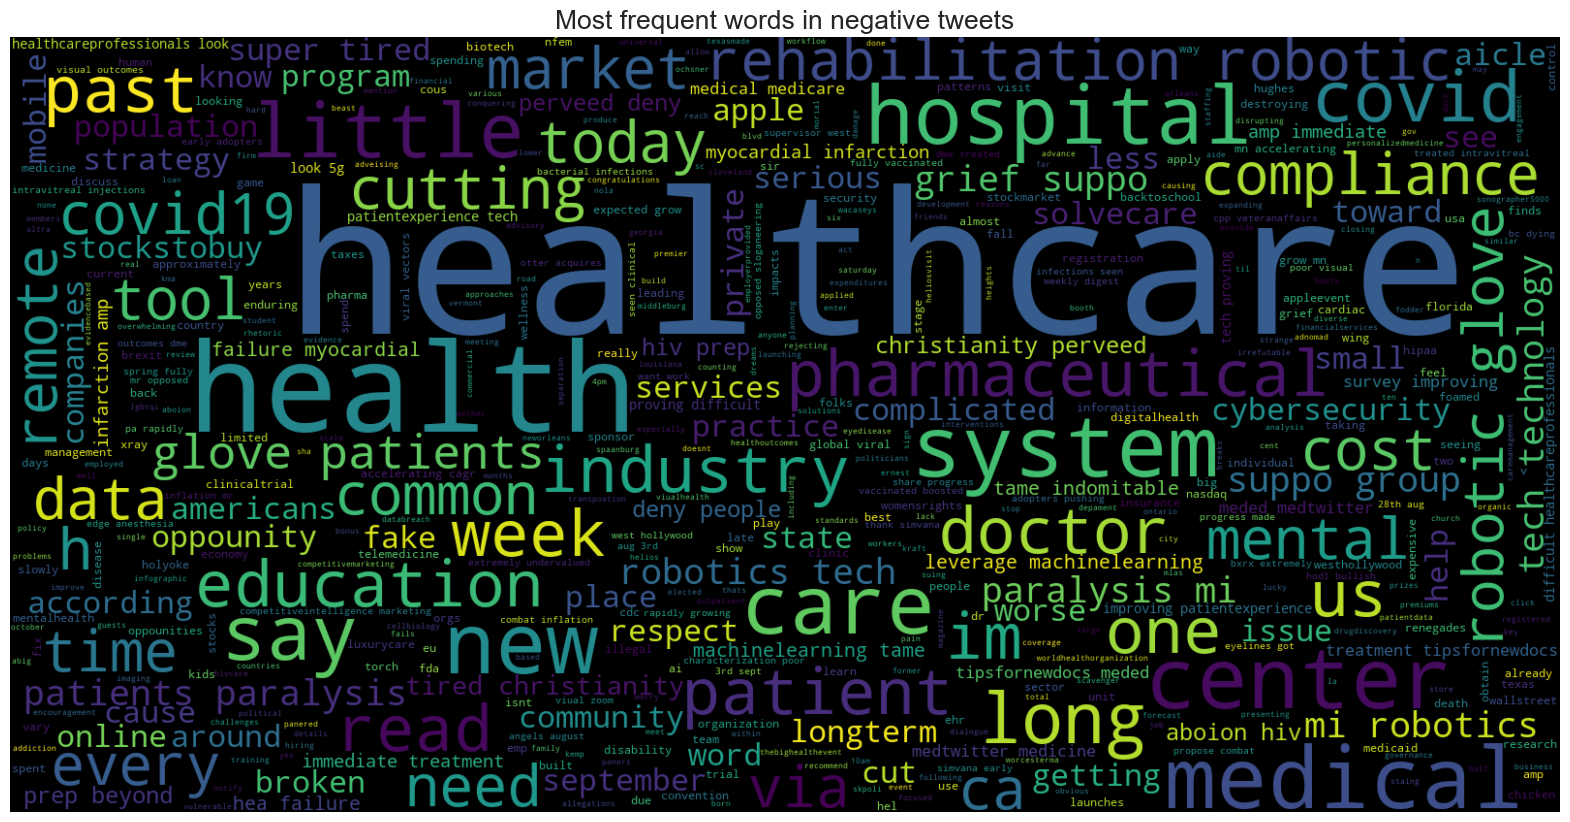

In [225]:
text = ' '.join([word for word in negative_tweets['tweet_clean_text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in negative tweets', fontsize=19)
plt.show()

The analysis of most frequent words in negative tweets revealed interesting topics. In this case, words like "healthcare," "hospitals," "cutting," "costs," "less,", ''long'' and "doctors" , '' remote'' are all indicative of potential issues or criticisms related to the NHS.
drawbacks: analysis based on only 1200 tweets use of social media is not representative of all population and older segments might be underepresented.


<div style="background-color:#005EB8; color:white; padding:20px; text-align:center; font-weight:bold; border-radius: 8px; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);">

<h2 style="font-size: 24px;">End of Analysis</h2>
    
</div>
